# Fraud Detection

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Standard plotly imports
#import plotly.plotly as py
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import iplot, init_notebook_mode
#import cufflinks
#import cufflinks as cf
import plotly.figure_factory as ff

# Using plotly + cufflinks in offline mode
init_notebook_mode(connected=True)
#cufflinks.go_offline(connected=True)

# Preprocessing, modelling and evaluating
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from xgboost import XGBClassifier
import xgboost as xgb

## Hyperopt modules
#from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING
from functools import partial

import os
import gc
#print(os.listdir("/Users/mingkuanwu/Desktop/Kaggle_Competetions/Fraud_Detection/input"))
print(os.listdir("/home/mingkuan/Desktop/Fraud_Detection/input"))

['test_identity.csv', 'test_transaction.csv', 'train_transaction.csv', 'train_identity.csv', 'sample_submission.csv']


# Import train data 
## Data Description: 2 tables
### Transaction Table:
1. `TransactionDT`: timedelta from a given reference datetime (not an actual timestamp)
2. `TransactionAMT`: transaction payment amount in USD
3. `ProductCD`: product code, the product for each transaction
4. `card1` - `card6`: payment card information, such as card type, card category, issue bank, country, etc.
5. `addr`: address
6. `dist`: distance
7. `P_ and (R__) emaildomain`: purchaser and recipient email domain
8. `C1`-`C14`: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
9. `D1`-`D15`: timedelta, such as days between previous transaction, etc.
10. `M1`-`M9`: match, such as names on card and address, etc.
11. `Vxxx`: Vesta engineered rich features, including ranking, counting, and other entity relations.

#### Categorical Features:
1. `ProductCD`
2. `card1` - `card6`
3. `addr1`, `addr2`
4. `P_emaildomain` `R_emaildomain`
5. `M1` - `M9`

####  Numerical `Vxxx`: 
"All Vesta features were derived as <font color='red'>numerical</font>. some of them are count of orders within a clustering, a time-period or condition, so the value is finite and has ordering (or ranking). I wouldn't recommend to treat any of them as categorical. If any of them resulted in binary by chance, it maybe worth trying."

### Identity Table:
1. Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions. 
2. They're collected by Vesta’s fraud protection system and digital security partners.
3. (The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

#### Categorical Features:
1. `DeviceType`
2. `DeviceInfo`
3. `id12` - `id38`

In [2]:
df_id = pd.read_csv("/home/mingkuan/Desktop/Fraud_Detection/input/train_identity.csv")
df_trans = pd.read_csv("/home/mingkuan/Desktop/Fraud_Detection/input/train_transaction.csv")
#df_id = pd.read_csv("/Users/mingkuanwu/Desktop/Kaggle_Competetions/Fraud_Detection/input/train_identity.csv")
#df_trans = pd.read_csv("/Users/mingkuanwu/Desktop/Kaggle_Competetions/Fraud_Detection/input/train_transaction.csv")

## reduce and resume table

In [2]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    #for name in summary['Name'].value_counts().index:
    #    summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

def CalcOutliers(df_num): 

    # calculating mean and std of the array
    data_mean, data_std = np.mean(df_num), np.std(df_num)

    # seting the cut line to both higher and lower values
    # You can change this value
    cut = data_std * 3

    #Calculating the higher and lower cut values
    lower, upper = data_mean - cut, data_mean + cut

    # creating an array of lower, higher and total outlier values 
    outliers_lower = [x for x in df_num if x < lower]
    outliers_higher = [x for x in df_num if x > upper]
    outliers_total = [x for x in df_num if x < lower or x > upper]

    # array without outlier values
    outliers_removed = [x for x in df_num if x > lower and x < upper]
    
    print('Identified lowest outliers: %d' % len(outliers_lower)) # printing total number of values in lower cut of outliers
    print('Identified upper outliers: %d' % len(outliers_higher)) # printing total number of values in higher cut of outliers
    print('Total outlier observations: %d' % len(outliers_total)) # printing total number of values outliers of both sides
    print('Non-outlier observations: %d' % len(outliers_removed)) # printing total number of non outlier values
    print("Total percentual of Outliers: ", round((len(outliers_total) / len(outliers_removed) )*100, 4)) # Percentual of outliers in points
    
    return

In [4]:
## Reducing memory
df_trans = reduce_mem_usage(df_trans)
df_id = reduce_mem_usage(df_id)

Mem. usage decreased to 542.35 Mb (69.4% reduction)
Mem. usage decreased to 25.86 Mb (42.7% reduction)


# 1. Exploration Data Analysis

In [5]:
resumetable(df_trans)[:60]

Dataset Shape: (590540, 394)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value
0,TransactionID,int32,0,590540,2987000,2987001,2987002
1,isFraud,int8,0,2,0,0,0
2,TransactionDT,int32,0,573349,86400,86401,86469
3,TransactionAmt,float16,0,8195,68.5,29,59
4,ProductCD,object,0,5,W,W,W
5,card1,int16,0,13553,13926,2755,4663
6,card2,float16,8933,500,NaN,404,490
7,card3,float16,1565,114,150,150,150
8,card4,object,1577,4,discover,mastercard,visa
9,card5,float16,4259,119,142,102,166


In [6]:
resumetable(df_id)

Dataset Shape: (144233, 41)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value
0,TransactionID,int32,0,144233,2987004,2987008,2987010
1,id_01,float16,0,77,0,-5,-5
2,id_02,float32,3361,115655,70787,98945,191631
3,id_03,float16,77909,24,NaN,NaN,0
4,id_04,float16,77909,15,NaN,NaN,0
5,id_05,float16,7368,93,NaN,0,0
6,id_06,float16,7368,101,NaN,-5,0
7,id_07,float16,139078,84,NaN,NaN,NaN
8,id_08,float16,139078,94,NaN,NaN,NaN
9,id_09,float16,69307,46,NaN,NaN,0


## 1.1. Target Distribution: # of fraud & transaction amt

In [7]:
df_trans['TransactionAmt'] = df_trans['TransactionAmt'].astype(float)
total = len(df_trans)
total_amt = df_trans.groupby(['isFraud'])['TransactionAmt'].sum().sum()

In [8]:
total, total_amt

(590540, 79739049.73706055)

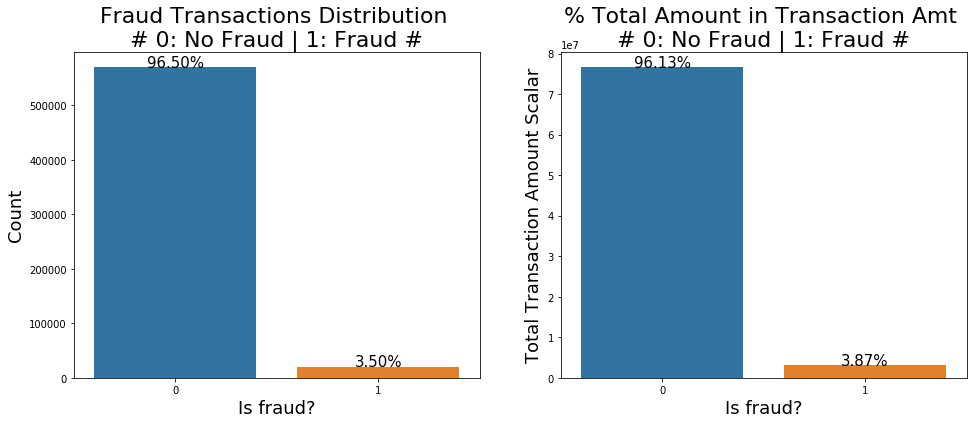

In [9]:
df_trans['TransactionAmt'] = df_trans['TransactionAmt'].astype(float)
total = len(df_trans)
total_amt = df_trans.groupby(['isFraud'])['TransactionAmt'].sum().sum()
plt.figure(figsize=(16,6))

plt.subplot(121)
g = sns.countplot(x='isFraud', data=df_trans, )
g.set_title("Fraud Transactions Distribution \n# 0: No Fraud | 1: Fraud #", fontsize=22)
g.set_xlabel("Is fraud?", fontsize=18)
g.set_ylabel('Count', fontsize=18)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=15) 

perc_amt = (df_trans.groupby(['isFraud'])['TransactionAmt'].sum())
perc_amt = perc_amt.reset_index()

plt.subplot(122)
g1 = sns.barplot(x='isFraud', y='TransactionAmt',  dodge=True, data=perc_amt)
g1.set_title("% Total Amount in Transaction Amt \n# 0: No Fraud | 1: Fraud #", fontsize=22)
g1.set_xlabel("Is fraud?", fontsize=18)
g1.set_ylabel('Total Transaction Amount Scalar', fontsize=18)
for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total_amt * 100),
            ha="center", fontsize=15) 
    
plt.show()

## transaction amt quantiles

In [10]:
df_trans['TransactionAmt'] = df_trans['TransactionAmt'].astype(float)
print("Transaction Amounts Quantiles: \n ----------------------------")
print(df_trans['TransactionAmt'].quantile([.01, .025, .1, .25, .5, .75, .9, .975, .99]))

Transaction Amounts Quantiles: 
 ----------------------------
0.010       9.242188
0.025      14.500000
0.100      25.953125
0.250      43.312500
0.500      68.750000
0.750     125.000000
0.900     275.250000
0.975     648.262500
0.990    1104.000000
Name: TransactionAmt, dtype: float64


## plot transaction amt 

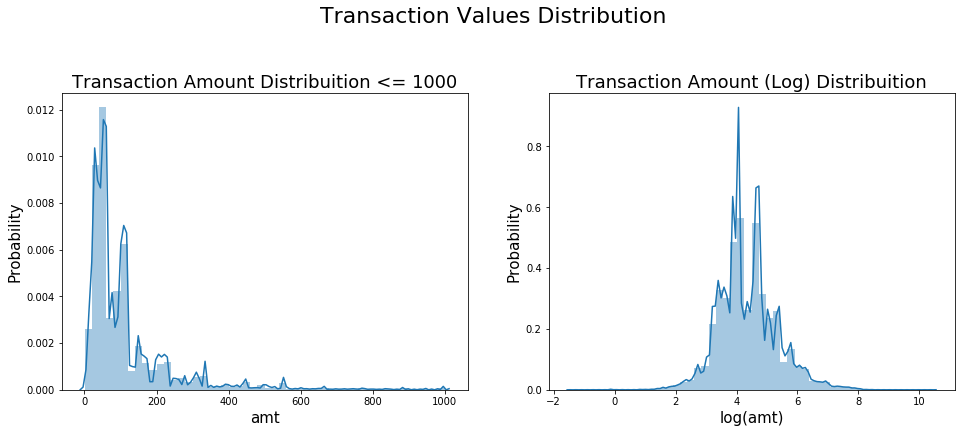

In [11]:
plt.figure(figsize=(16,12))
plt.suptitle('Transaction Values Distribution', fontsize=22)
plt.subplot(221)
g = sns.distplot(df_trans[df_trans['TransactionAmt'] <= 1000]['TransactionAmt'])
g.set_title("Transaction Amount Distribuition <= 1000", fontsize=18)
g.set_xlabel("amt", fontsize=15)
g.set_ylabel("Probability", fontsize=15)

plt.subplot(222)
g1 = sns.distplot(np.log(df_trans['TransactionAmt']))
g1.set_title("Transaction Amount (Log) Distribuition", fontsize=18)
g1.set_xlabel("log(amt)", fontsize=15)
g1.set_ylabel("Probability", fontsize=15)

plt.show()

## Quantiles of fraud and non-fraud amt

In [12]:
print(pd.concat([df_trans[df_trans['isFraud'] == 1]['TransactionAmt']\
                 .quantile([.01, .1, .25, .5, .75, .9, .99])\
                 .reset_index(), 
                 df_trans[df_trans['isFraud'] == 0]['TransactionAmt']\
                 .quantile([.01, .1, .25, .5, .75, .9, .99])\
                 .reset_index()],
                axis=1, keys=['Fraud', "No Fraud"]))

  Fraud                No Fraud               
  index TransactionAmt    index TransactionAmt
0  0.01       6.739453     0.01       9.511875
1  0.10      18.937500     0.10      26.312500
2  0.25      35.031250     0.25      43.968750
3  0.50      75.000000     0.50      68.500000
4  0.75     161.000000     0.75     120.000000
5  0.90     335.000000     0.90     267.100000
6  0.99     994.000000     0.99    1104.000000


## transaction amt 3-std outliers

In [13]:
CalcOutliers(df_trans['TransactionAmt'])

Identified lowest outliers: 0
Identified upper outliers: 10097
Total outlier observations: 10097
Non-outlier observations: 580443
Total percentual of Outliers:  1.7395


## 1.2. Explore <font color='red'>categorical</font> variables in <font color='red'>transaction table</font>:
### 1.2.1. `'ProductCD'`: product code, the product for each transaction (categorical)

In [14]:
tmp = pd.crosstab(df_trans['ProductCD'], df_trans['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
tmp

isFraud,ProductCD,NoFraud,Fraud
0,C,88.312731,11.687269
1,H,95.233769,4.766231
2,R,96.217406,3.782594
3,S,94.100447,5.899553
4,W,97.960061,2.039939


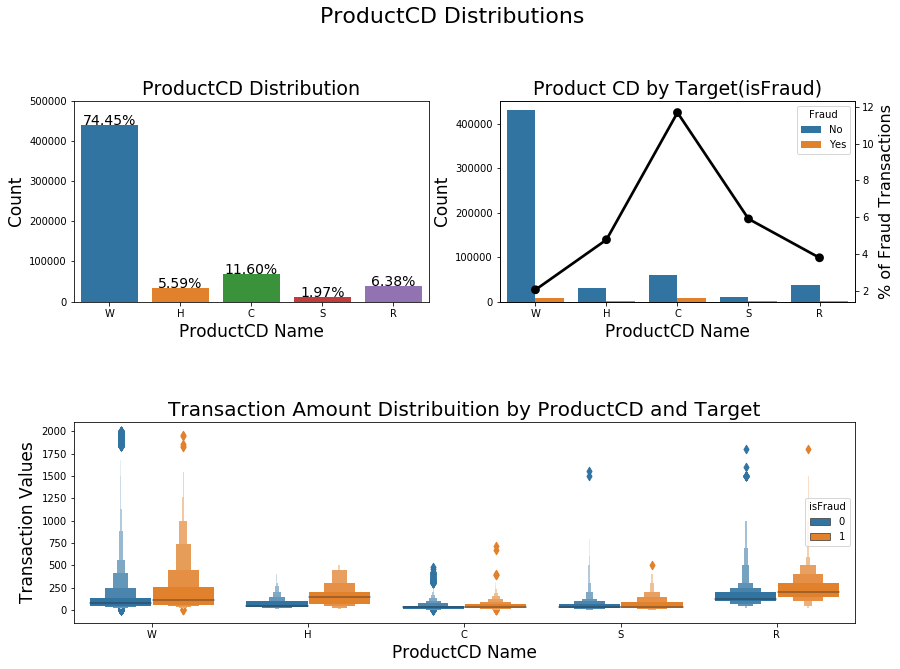

In [15]:
plt.figure(figsize=(14,10))
plt.suptitle('ProductCD Distributions', fontsize=22)

plt.subplot(221)
g = sns.countplot(x='ProductCD', data=df_trans)
#plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])

g.set_title("ProductCD Distribution", fontsize=19)
g.set_xlabel("ProductCD Name", fontsize=17)
g.set_ylabel("Count", fontsize=17)
g.set_ylim(0,500000)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 

plt.subplot(222)
g1 = sns.countplot(x='ProductCD', hue='isFraud', data=df_trans)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
gt = g1.twinx()
gt = sns.pointplot(x='ProductCD', y='Fraud', data=tmp, color='black', order=['W', 'H',"C", "S", "R"], legend=False)
gt.set_ylabel("% of Fraud Transactions", fontsize=16)

g1.set_title("Product CD by Target(isFraud)", fontsize=19)
g1.set_xlabel("ProductCD Name", fontsize=17)
g1.set_ylabel("Count", fontsize=17)

plt.subplot(212)
g3 = sns.boxenplot(x='ProductCD', y='TransactionAmt', hue='isFraud', 
              data=df_trans[df_trans['TransactionAmt'] <= 2000] )
g3.set_title("Transaction Amount Distribuition by ProductCD and Target", fontsize=20)
g3.set_xlabel("ProductCD Name", fontsize=17)
g3.set_ylabel("Transaction Values", fontsize=17)

plt.subplots_adjust(hspace = 0.6, top = 0.85)

plt.show()

### 1.2.2. transaction table: Card feature `card1 - card6`
1. Based on Competition Description, card features are categoricals.
2. What's the different in transactions and % of Fraud for each values in these features
3. 6 card features, 4 of them are numerical

In [16]:
df_trans[['card1', 'card2', 'card3','card4', 'card5', 'card6']].head(10)

,card1,card2,card3,card4,card5,card6
0,13926,NaN,150.0,discover,142.0,credit
1,2755,404.0,150.0,mastercard,102.0,credit
2,4663,490.0,150.0,visa,166.0,debit
3,18132,567.0,150.0,mastercard,117.0,debit
4,4497,514.0,150.0,mastercard,102.0,credit
5,5937,555.0,150.0,visa,226.0,debit
6,12308,360.0,150.0,visa,166.0,debit
7,12695,490.0,150.0,visa,226.0,debit
8,2803,100.0,150.0,visa,226.0,debit
9,17399,111.0,150.0,mastercard,224.0,debit


In [17]:
resumetable(df_trans[['card1', 'card2', 'card3','card4', 'card5', 'card6']])

Dataset Shape: (590540, 6)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value
0,card1,int16,0,13553,13926,2755,4663
1,card2,float16,8933,500,NaN,404,490
2,card3,float16,1565,114,150,150,150
3,card4,object,1577,4,discover,mastercard,visa
4,card5,float16,4259,119,142,102,166
5,card6,object,1571,4,credit,credit,debit


#### Numerical Card Features Quantiles
card 1, 2 ,3 and 5

In [18]:
print("Card Features Quantiles: ")
print(df_trans[['card1', 'card2', 'card3', 'card5']].quantile([0.01, .025, .1, .25, .5, .75, .975, .99]))

Card Features Quantiles: 
         card1  card2  card3  card5
0.010   1338.0  100.0  144.0  102.0
0.025   1675.0  111.0  150.0  102.0
0.100   2803.0  111.0  150.0  126.0
0.250   6019.0  214.0  150.0  166.0
0.500   9678.0  361.0  150.0  226.0
0.750  14184.0  512.0  150.0  226.0
0.975  18018.0  583.0  185.0  226.0
0.990  18238.0  583.0  185.0  226.0


card 1 and 2 have large distriution values, we may use log transformation.

In [19]:
df_trans.loc[df_trans.card3.isin(df_trans.card3.value_counts()[df_trans.card3.value_counts() < 200].index), 'card3'] = "Others"
df_trans.loc[df_trans.card5.isin(df_trans.card5.value_counts()[df_trans.card5.value_counts() < 300].index), 'card5'] = "Others"

In [20]:
df_trans.card3.value_counts().index

Index([   150.0,    185.0, 'Others',    106.0,    146.0,    144.0,    117.0,
          143.0,    119.0,    102.0,    147.0,    162.0,    203.0,    213.0,
          100.0],
      dtype='object')

In [21]:
df_trans.card5.value_counts().index

Index([   226.0,    224.0,    166.0,    102.0,    117.0,    138.0,    195.0,
          137.0,    126.0,    219.0,    202.0,    162.0, 'Others',    229.0,
          197.0,    150.0,    100.0,    223.0,    118.0,    190.0,    146.0,
          198.0,    236.0,    185.0,    203.0,    147.0,    141.0,    129.0],
      dtype='object')

#### Card 1, 2, 3 and 5 distribution

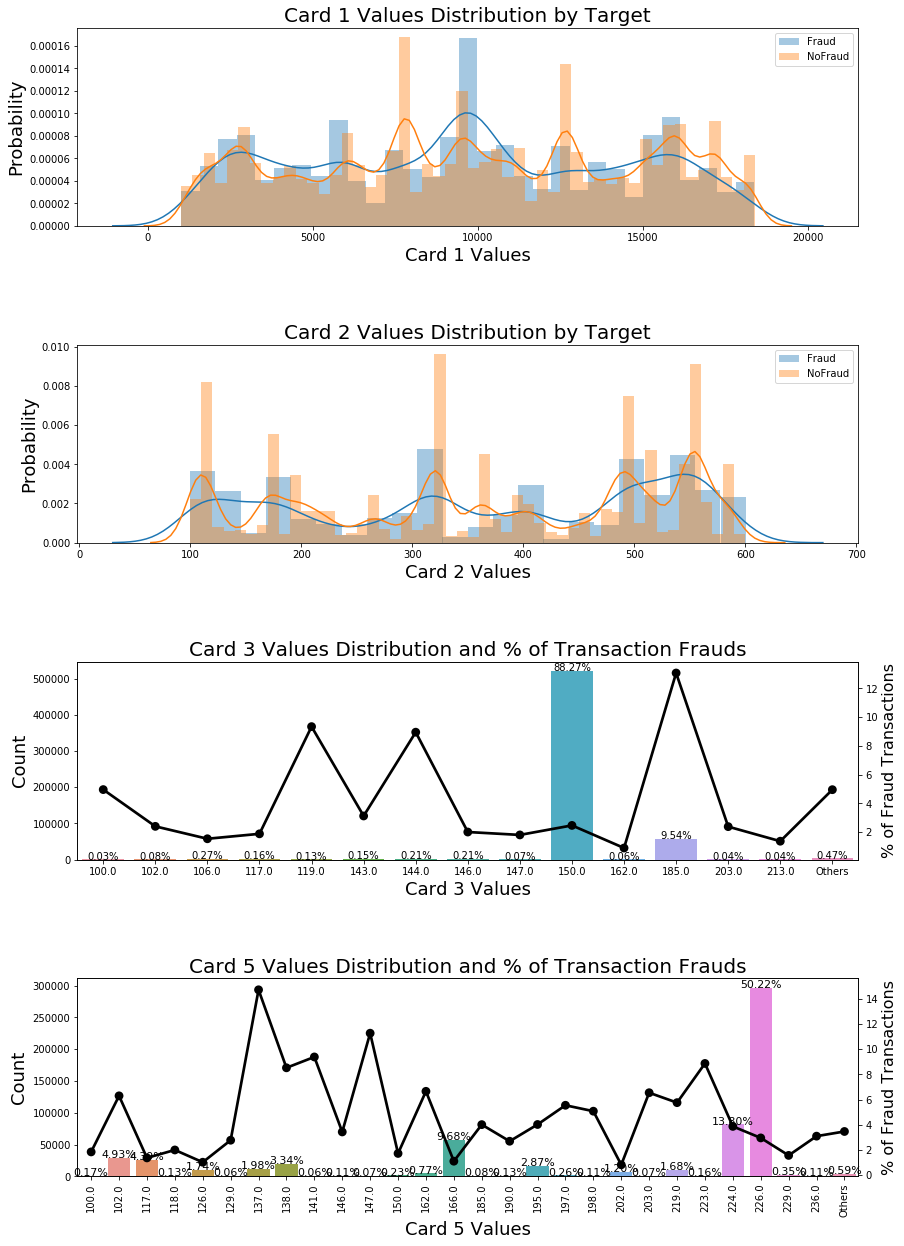

In [22]:
tmp = pd.crosstab(df_trans['card3'], df_trans['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

tmp2 = pd.crosstab(df_trans['card5'], df_trans['isFraud'], normalize='index') * 100
tmp2 = tmp2.reset_index()
tmp2.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(14,22))

plt.subplot(411)
g = sns.distplot(df_trans[df_trans['isFraud'] == 1]['card1'], label='Fraud')
g = sns.distplot(df_trans[df_trans['isFraud'] == 0]['card1'], label='NoFraud')
g.legend()
g.set_title("Card 1 Values Distribution by Target", fontsize=20)
g.set_xlabel("Card 1 Values", fontsize=18)
g.set_ylabel("Probability", fontsize=18)

plt.subplot(412)
g1 = sns.distplot(df_trans[df_trans['isFraud'] == 1]['card2'].dropna(), label='Fraud')
g1 = sns.distplot(df_trans[df_trans['isFraud'] == 0]['card2'].dropna(), label='NoFraud')
g1.legend()
g1.set_title("Card 2 Values Distribution by Target", fontsize=20)
g1.set_xlabel("Card 2 Values", fontsize=18)
g1.set_ylabel("Probability", fontsize=18)

plt.subplot(413)
g2 = sns.countplot(x='card3', data=df_trans, order=list(tmp.card3.values))
g22 = g2.twinx()
gg2 = sns.pointplot(x='card3', y='Fraud', data=tmp, 
                    color='black', order=list(tmp.card3.values))
gg2.set_ylabel("% of Fraud Transactions", fontsize=16)
g2.set_title("Card 3 Values Distribution and % of Transaction Frauds", fontsize=20)
g2.set_xlabel("Card 3 Values", fontsize=18)
g2.set_ylabel("Count", fontsize=18)
for p in g2.patches:
    height = p.get_height()
    g2.text(p.get_x()+p.get_width()/2.,
            height + 25,
            '{:1.2f}%'.format(height/total*100),
            ha="center") 

plt.subplot(414)
g3 = sns.countplot(x='card5', data=df_trans, order=list(tmp2.card5.values))
g3t = g3.twinx()
g3t = sns.pointplot(x='card5', y='Fraud', data=tmp2, 
                    color='black', order=list(tmp2.card5.values))
g3t.set_ylabel("% of Fraud Transactions", fontsize=16)
g3.set_title("Card 5 Values Distribution and % of Transaction Frauds", fontsize=20)
g3.set_xticklabels(g3.get_xticklabels(),rotation=90)
g3.set_xlabel("Card 5 Values", fontsize=18)
g3.set_ylabel("Count", fontsize=18)
for p in g3.patches:
    height = p.get_height()
    g3.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center",fontsize=11) 
    
plt.subplots_adjust(hspace = 0.6, top = 0.85)


plt.show()

#### Card 4 categorical feature

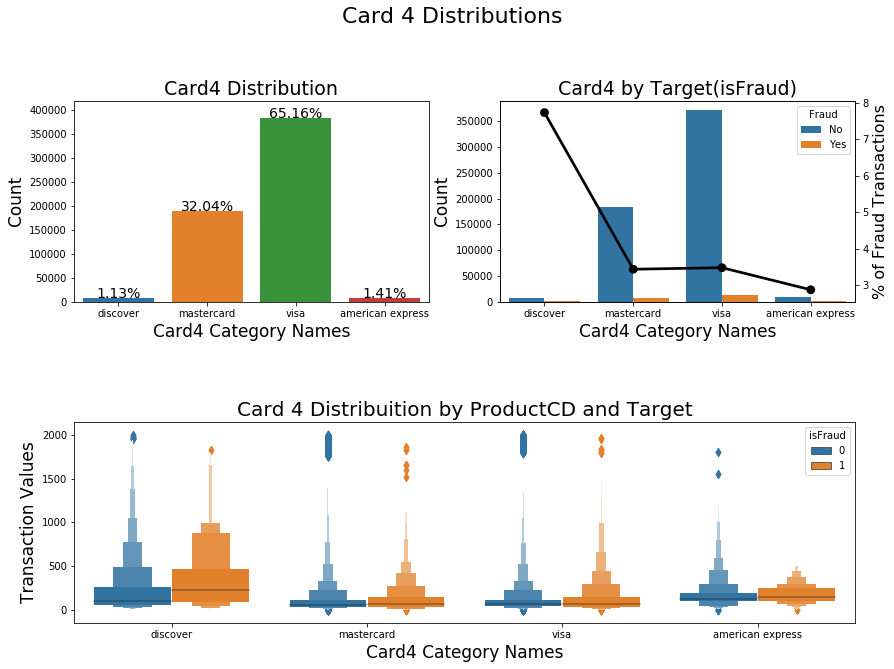

In [23]:
tmp = pd.crosstab(df_trans['card4'], df_trans['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(14,10))
plt.suptitle('Card 4 Distributions', fontsize=22)

plt.subplot(221)
g = sns.countplot(x='card4', data=df_trans)
# plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])
g.set_title("Card4 Distribution", fontsize=19)
g.set_ylim(0,420000)
g.set_xlabel("Card4 Category Names", fontsize=17)
g.set_ylabel("Count", fontsize=17)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center",fontsize=14) 


plt.subplot(222)
g1 = sns.countplot(x='card4', hue='isFraud', data=df_trans)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
gt = g1.twinx()
gt = sns.pointplot(x='card4', y='Fraud', data=tmp, 
                   color='black', legend=False, 
                   order=['discover', 'mastercard', 'visa', 'american express'])
gt.set_ylabel("% of Fraud Transactions", fontsize=16)
g1.set_title("Card4 by Target(isFraud)", fontsize=19)
g1.set_xlabel("Card4 Category Names", fontsize=17)
g1.set_ylabel("Count", fontsize=17)

plt.subplot(212)
g3 = sns.boxenplot(x='card4', y='TransactionAmt', hue='isFraud', 
              data=df_trans[df_trans['TransactionAmt'] <= 2000] )
g3.set_title("Card 4 Distribuition by ProductCD and Target", fontsize=20)
g3.set_xlabel("Card4 Category Names", fontsize=17)
g3.set_ylabel("Transaction Values", fontsize=17)

plt.subplots_adjust(hspace = 0.6, top = 0.85)

plt.show()

#### Card 6 categorical feature

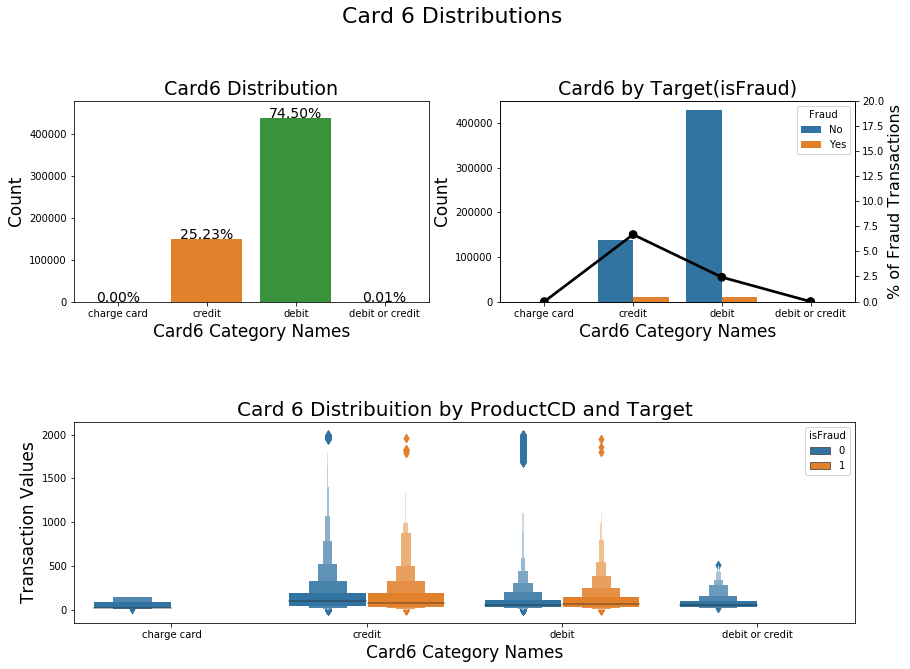

In [24]:
tmp = pd.crosstab(df_trans['card6'], df_trans['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(14,10))
plt.suptitle('Card 6 Distributions', fontsize=22)

plt.subplot(221)
g = sns.countplot(x='card6', data=df_trans, order=list(tmp.card6.values))
# plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])
g.set_title("Card6 Distribution", fontsize=19)
g.set_ylim(0,480000)
g.set_xlabel("Card6 Category Names", fontsize=17)
g.set_ylabel("Count", fontsize=17)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center",fontsize=14) 

plt.subplot(222)
g1 = sns.countplot(x='card6', hue='isFraud', data=df_trans, order=list(tmp.card6.values))
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
gt = g1.twinx()
gt = sns.pointplot(x='card6', y='Fraud', data=tmp, order=list(tmp.card6.values),
                   color='black', legend=False, )
gt.set_ylim(0,20)
gt.set_ylabel("% of Fraud Transactions", fontsize=16)
g1.set_title("Card6 by Target(isFraud)", fontsize=19)
g1.set_xlabel("Card6 Category Names", fontsize=17)
g1.set_ylabel("Count", fontsize=17)

plt.subplot(212)
g3 = sns.boxenplot(x='card6', y='TransactionAmt', hue='isFraud', order=list(tmp.card6.values),
              data=df_trans[df_trans['TransactionAmt'] <= 2000] )
g3.set_title("Card 6 Distribuition by ProductCD and Target", fontsize=20)
g3.set_xlabel("Card6 Category Names", fontsize=17)
g3.set_ylabel("Transaction Values", fontsize=17)

plt.subplots_adjust(hspace = 0.6, top = 0.85)

plt.show()

### 1.2.3. Explore `'M1' - 'M9'` Features
####     Count, %Fraud and Transaction Amount distribution

In [25]:
for col in ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']:
    df_trans[col] = df_trans[col].fillna("Miss")
    
def ploting_dist_ratio(df, col, lim=2000):
    tmp = pd.crosstab(df[col], df['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

    plt.figure(figsize=(20,5))
    plt.suptitle(f'{col} Distributions ', fontsize=22)

    plt.subplot(121)
    g = sns.countplot(x=col, data=df, order=list(tmp[col].values))
    # plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])
    g.set_title(f"{col} Distribution\nCount and %Fraud by each category", fontsize=18)
    g.set_ylim(0,400000)
    gt = g.twinx()
    gt = sns.pointplot(x=col, y='Fraud', data=tmp, order=list(tmp[col].values),
                       color='black', legend=False, )
    gt.set_ylim(0,20)
    gt.set_ylabel("% of Fraud Transactions", fontsize=16)
    g.set_xlabel(f"{col} Category Names", fontsize=16)
    g.set_ylabel("Count", fontsize=17)
    for p in gt.patches:
        height = p.get_height()
        gt.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center",fontsize=14) 
        
    perc_amt = (df_trans.groupby(['isFraud',col])['TransactionAmt'].sum() / total_amt * 100).unstack('isFraud')
    perc_amt = perc_amt.reset_index()
    perc_amt.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

    plt.subplot(122)
    g1 = sns.boxplot(x=col, y='TransactionAmt', hue='isFraud', 
                     data=df[df['TransactionAmt'] <= lim], order=list(tmp[col].values))
    g1t = g1.twinx()
    g1t = sns.pointplot(x=col, y='Fraud', data=perc_amt, order=list(tmp[col].values),
                       color='black', legend=False, )
    g1t.set_ylim(0,5)
    g1t.set_ylabel("%Fraud Total Amount", fontsize=16)
    g1.set_title(f"{col} by Transactions dist", fontsize=18)
    g1.set_xlabel(f"{col} Category Names", fontsize=16)
    g1.set_ylabel("Transaction Amount(U$)", fontsize=16)
        
    plt.subplots_adjust(hspace=.4, wspace = 0.35, top = 0.80)
    
    plt.show()

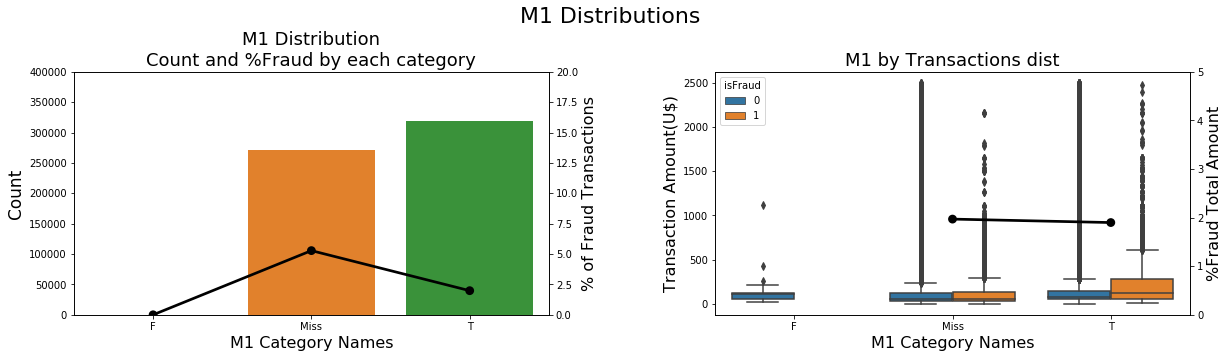

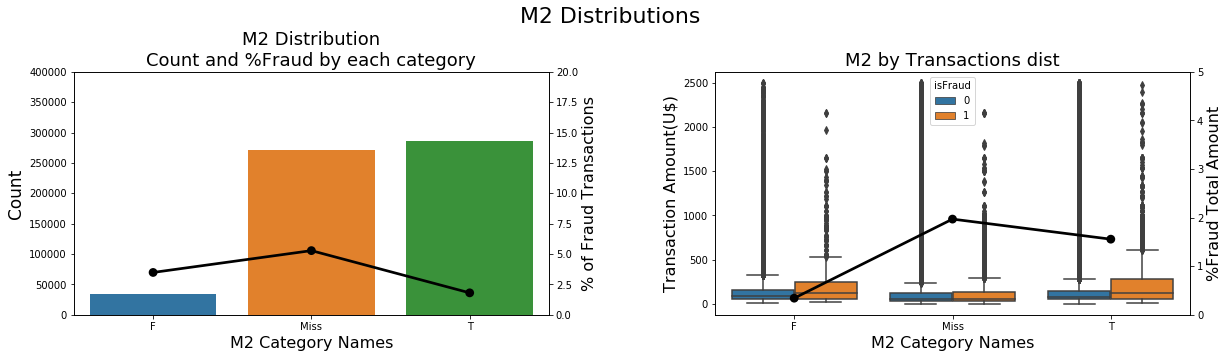

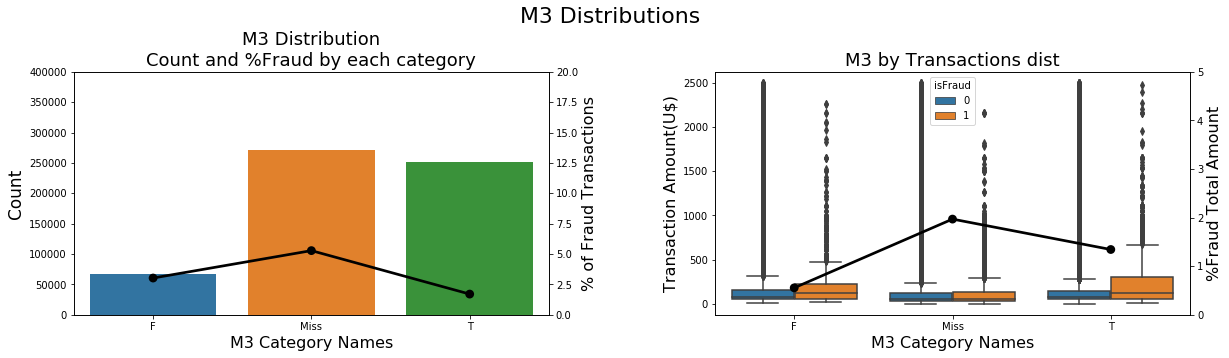

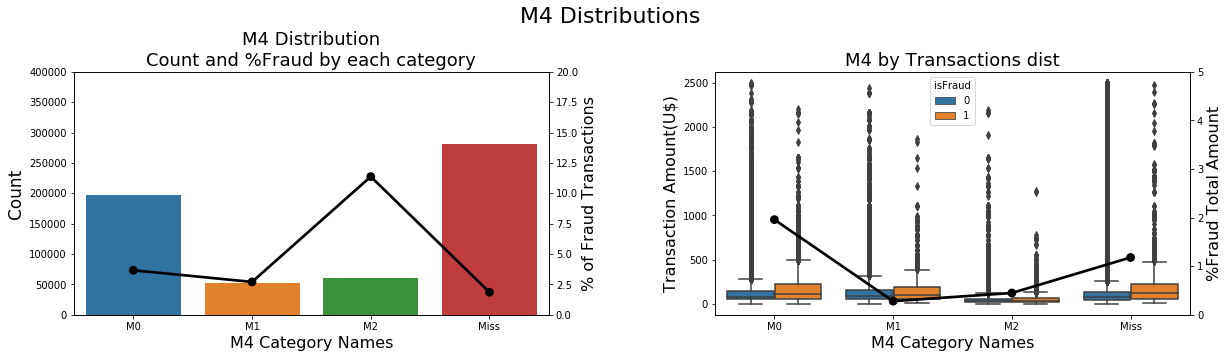

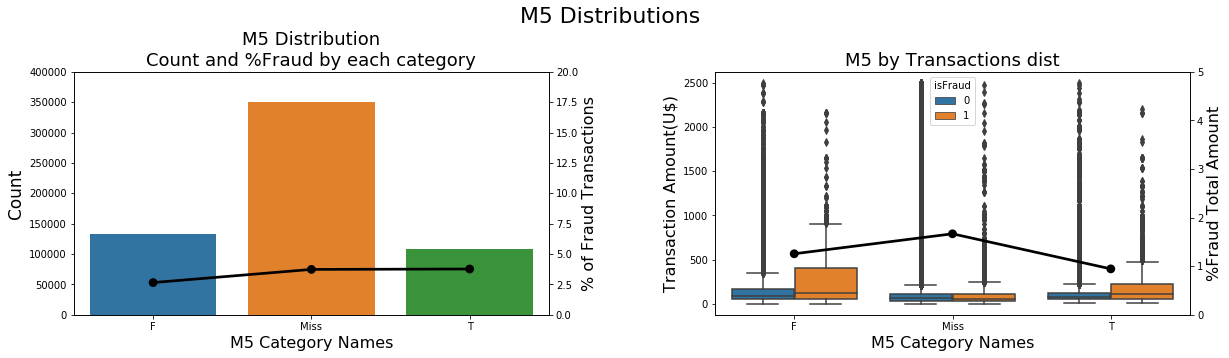

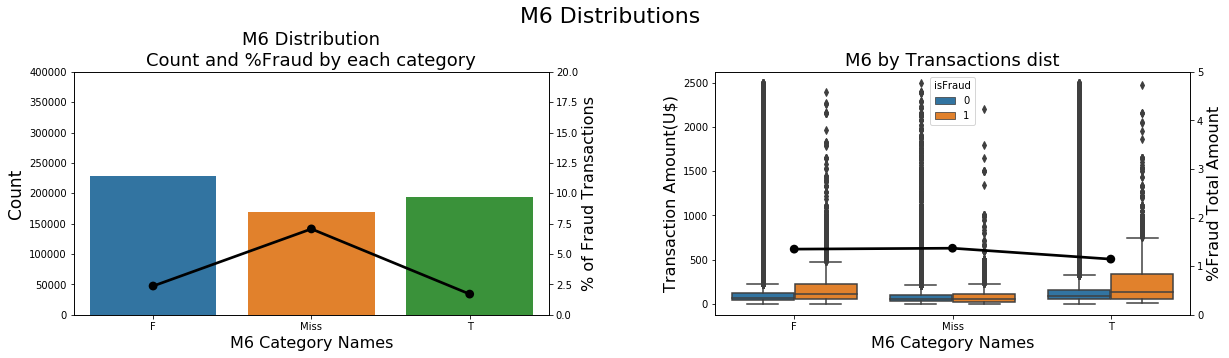

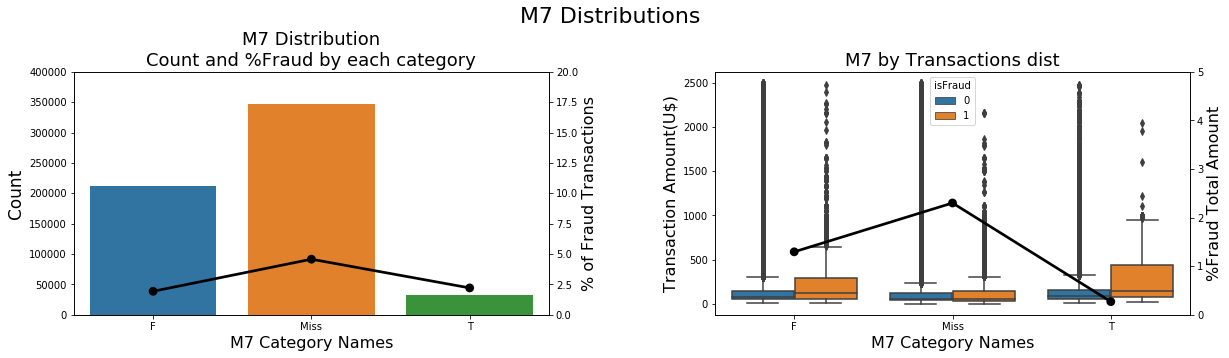

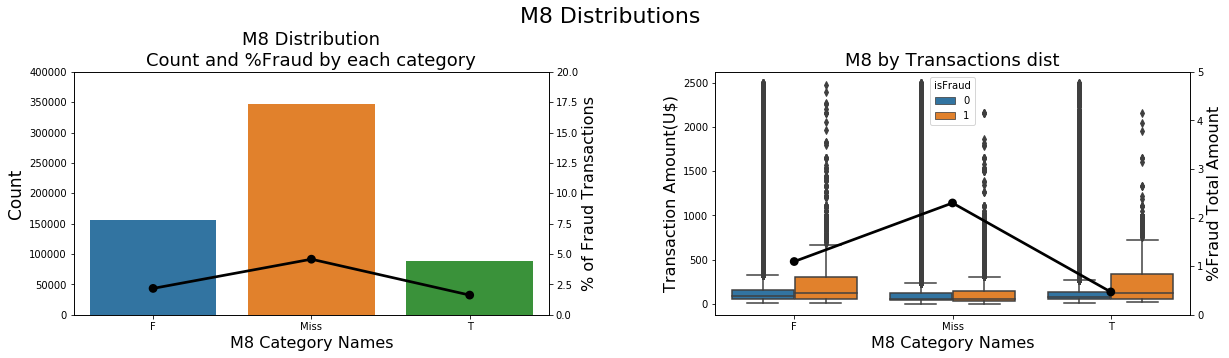

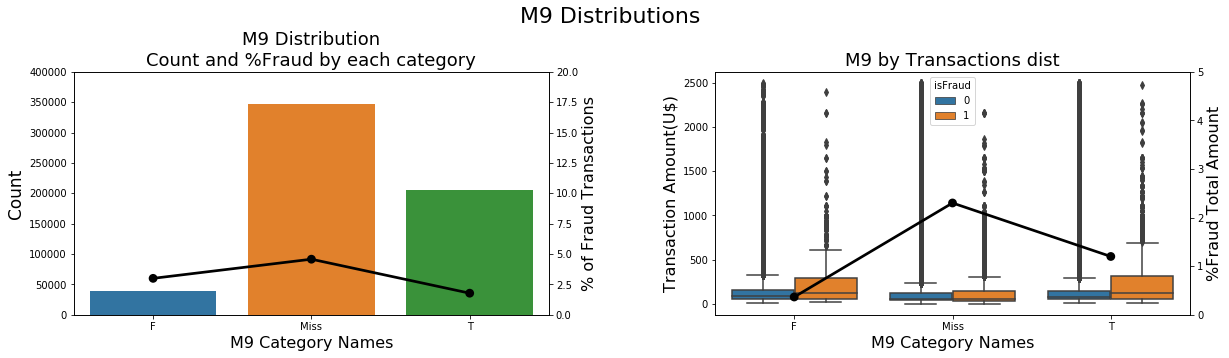

In [26]:
for col in ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']:
    ploting_dist_ratio(df_trans, col, lim=2500)

### 1.2.4. Addr1 and Addr2 

In [27]:
print("Card Features Quantiles: ")
print(df_trans[['addr1', 'addr2']].quantile([0.01, .025, .1, .25, .5, .75, .90,.975, .99]))

Card Features Quantiles: 
       addr1  addr2
0.010  123.0   87.0
0.025  123.0   87.0
0.100  177.0   87.0
0.250  204.0   87.0
0.500  299.0   87.0
0.750  330.0   87.0
0.900  441.0   87.0
0.975  498.0   87.0
0.990  512.0   87.0


In [28]:
df_trans.loc[df_trans.addr1.isin(df_trans.addr1.value_counts()[df_trans.addr1.value_counts() <= 5000 ].index), 'addr1'] = "Others"
df_trans.loc[df_trans.addr2.isin(df_trans.addr2.value_counts()[df_trans.addr2.value_counts() <= 50 ].index), 'addr2'] = "Others"

In [29]:
def ploting_cnt_amt(df, col, lim=2000):
    tmp = pd.crosstab(df[col], df['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
    
    plt.figure(figsize=(16,14))    
    plt.suptitle(f'{col} Distributions ', fontsize=24)
    
    plt.subplot(211)
    g = sns.countplot( x=col,  data=df, order=list(tmp[col].values))
    gt = g.twinx()
    gt = sns.pointplot(x=col, y='Fraud', data=tmp, order=list(tmp[col].values),
                       color='black', legend=False, )
    gt.set_ylim(0,tmp['Fraud'].max()*1.1)
    gt.set_ylabel("%Fraud Transactions", fontsize=16)
    g.set_title(f"Most Frequent {col} values and % Fraud Transactions", fontsize=20)
    g.set_xlabel(f"{col} Category Names", fontsize=16)
    g.set_ylabel("Count", fontsize=17)
    g.set_xticklabels(g.get_xticklabels(),rotation=45)
    sizes = []
    for p in g.patches:
        height = p.get_height()
        sizes.append(height)
        g.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center",fontsize=12) 
        
    g.set_ylim(0,max(sizes)*1.15)
    
    #########################################################################
    perc_amt = (df.groupby(['isFraud',col])['TransactionAmt'].sum() \
                / df.groupby([col])['TransactionAmt'].sum() * 100).unstack('isFraud')
    perc_amt = perc_amt.reset_index()
    perc_amt.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
    amt = df.groupby([col])['TransactionAmt'].sum().reset_index()
    perc_amt = perc_amt.fillna(0)
    plt.subplot(212)
    g1 = sns.barplot(x=col, y='TransactionAmt', 
                       data=amt, 
                       order=list(tmp[col].values))
    g1t = g1.twinx()
    g1t = sns.pointplot(x=col, y='Fraud', data=perc_amt, 
                        order=list(tmp[col].values),
                       color='black', legend=False, )
    g1t.set_ylim(0,perc_amt['Fraud'].max()*1.1)
    g1t.set_ylabel("%Fraud Total Amount", fontsize=16)
    g.set_xticklabels(g.get_xticklabels(),rotation=45)
    g1.set_title(f"{col} by Transactions Total + %of total and %Fraud Transactions", fontsize=20)
    g1.set_xlabel(f"{col} Category Names", fontsize=16)
    g1.set_ylabel("Transaction Total Amount(U$)", fontsize=16)
    g1.set_xticklabels(g.get_xticklabels(),rotation=45)    
    
    for p in g1.patches:
        height = p.get_height()
        g1.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total_amt*100),
                ha="center",fontsize=12) 
        
    plt.subplots_adjust(hspace=.4, top = 0.9)
    plt.show()

#### Addr1

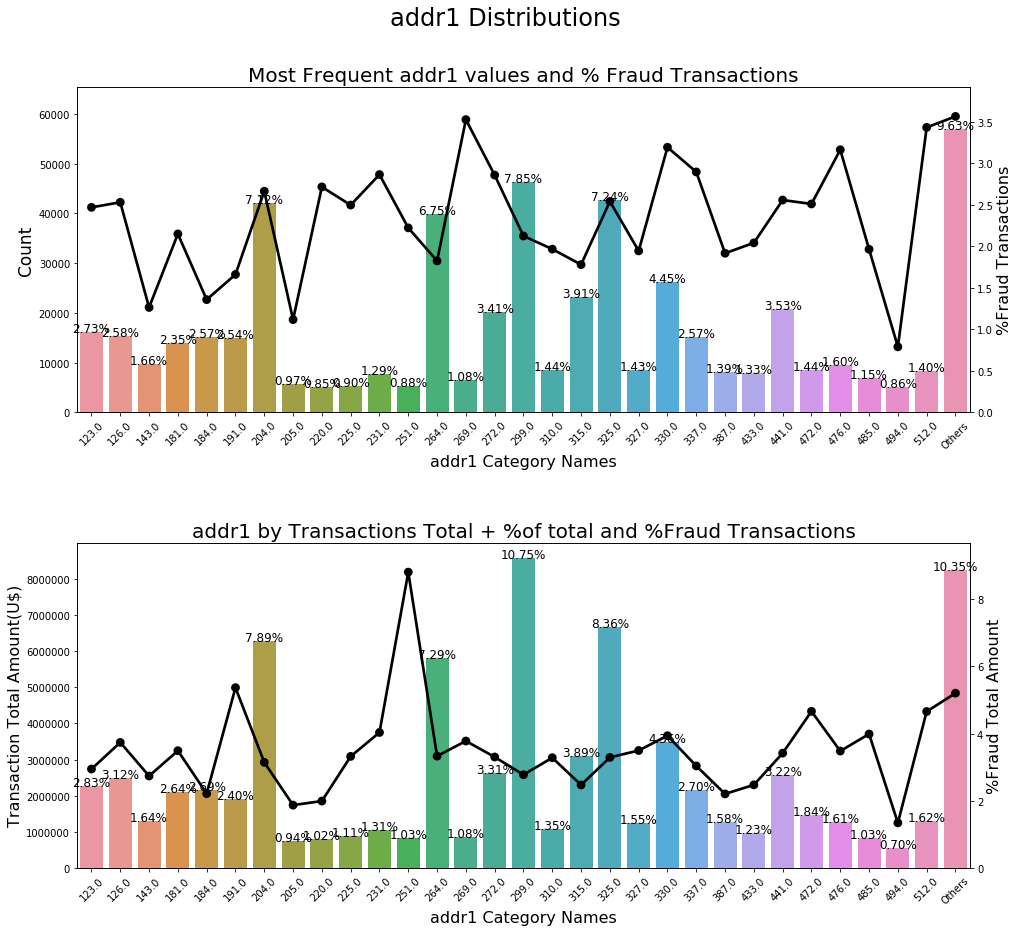

In [30]:
ploting_cnt_amt(df_trans, 'addr1')

#### Addr2

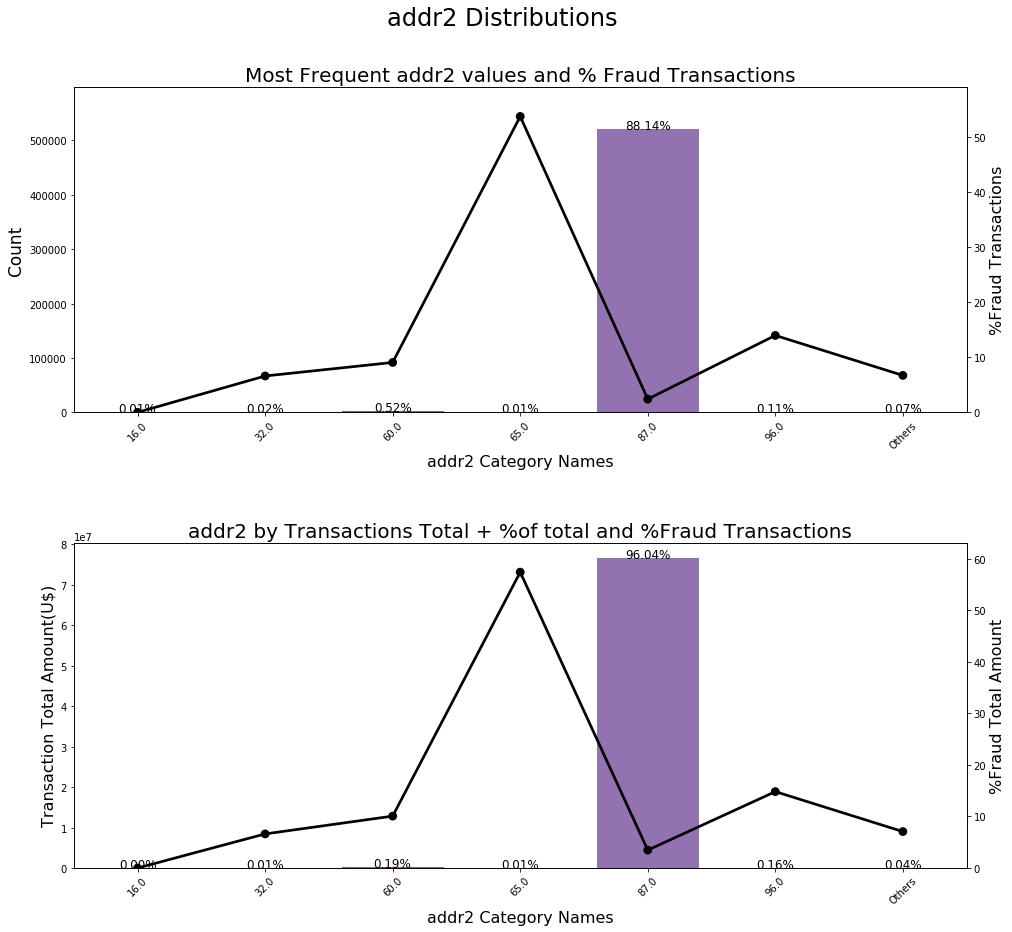

In [31]:
ploting_cnt_amt(df_trans, 'addr2')

### 1.2.5. `'P_emaildomain'` Distributions

In [32]:
df_trans.loc[df_trans['P_emaildomain'].isin(['gmail.com', 'gmail']),'P_emaildomain'] = 'Google'

df_trans.loc[df_trans['P_emaildomain'].isin(['yahoo.com', 'yahoo.com.mx',  'yahoo.co.uk',
                                         'yahoo.co.jp', 'yahoo.de', 'yahoo.fr',
                                         'yahoo.es']), 'P_emaildomain'] = 'Yahoo Mail'
df_trans.loc[df_trans['P_emaildomain'].isin(['hotmail.com','outlook.com','msn.com', 'live.com.mx', 
                                         'hotmail.es','hotmail.co.uk', 'hotmail.de',
                                         'outlook.es', 'live.com', 'live.fr',
                                         'hotmail.fr']), 'P_emaildomain'] = 'Microsoft'
df_trans.loc[df_trans.P_emaildomain.isin(df_trans.P_emaildomain\
                                         .value_counts()[df_trans.P_emaildomain.value_counts() <= 500 ]\
                                         .index), 'P_emaildomain'] = "Others"
df_trans.P_emaildomain.fillna("NoInf", inplace=True)

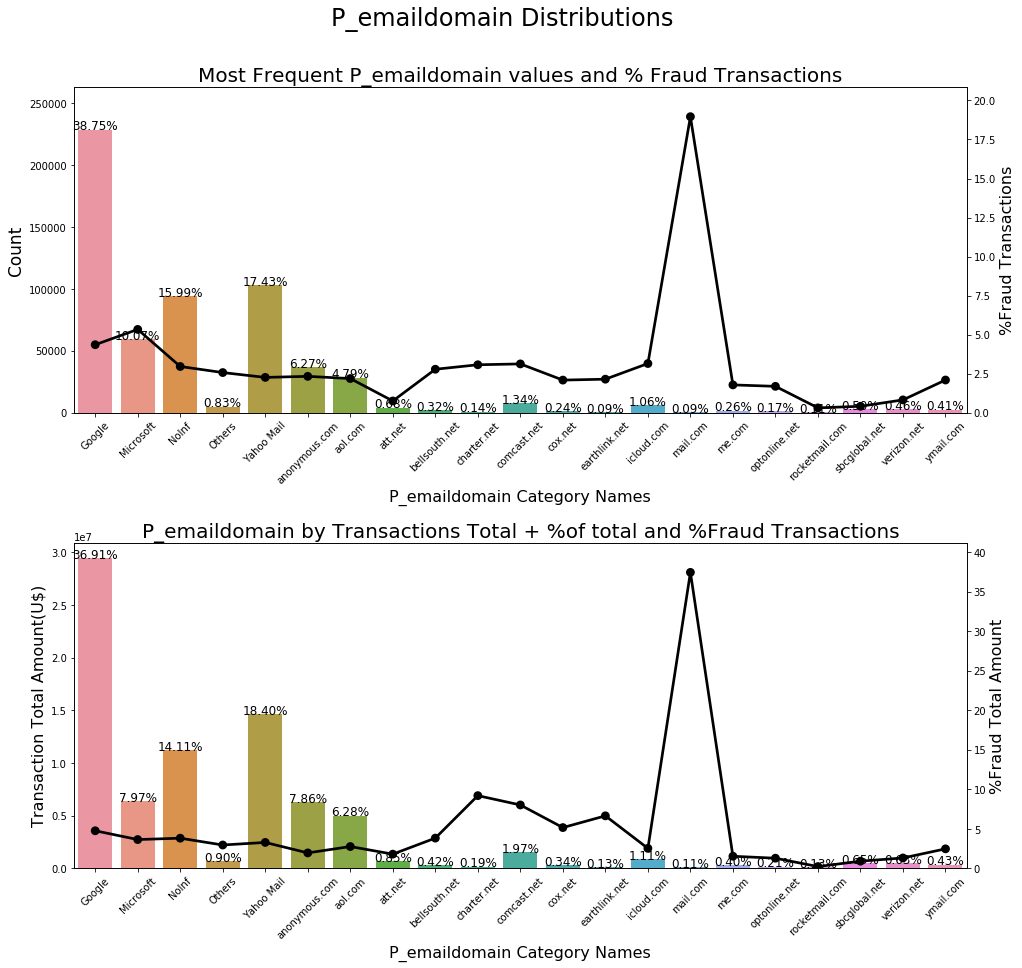

In [33]:
ploting_cnt_amt(df_trans, 'P_emaildomain')

### 1.2.6. `'R_emaildomain'` plot distribution

In [34]:
df_trans.loc[df_trans['R_emaildomain'].isin(['gmail.com', 'gmail']),'R_emaildomain'] = 'Google'

df_trans.loc[df_trans['R_emaildomain'].isin(['yahoo.com', 'yahoo.com.mx',  'yahoo.co.uk',
                                             'yahoo.co.jp', 'yahoo.de', 'yahoo.fr',
                                             'yahoo.es']), 'R_emaildomain'] = 'Yahoo Mail'
df_trans.loc[df_trans['R_emaildomain'].isin(['hotmail.com','outlook.com','msn.com', 'live.com.mx', 
                                             'hotmail.es','hotmail.co.uk', 'hotmail.de',
                                             'outlook.es', 'live.com', 'live.fr',
                                             'hotmail.fr']), 'R_emaildomain'] = 'Microsoft'
df_trans.loc[df_trans.R_emaildomain.isin(df_trans.R_emaildomain\
                                         .value_counts()[df_trans.R_emaildomain.value_counts() <= 300 ]\
                                         .index), 'R_emaildomain'] = "Others"
df_trans.R_emaildomain.fillna("NoInf", inplace=True)

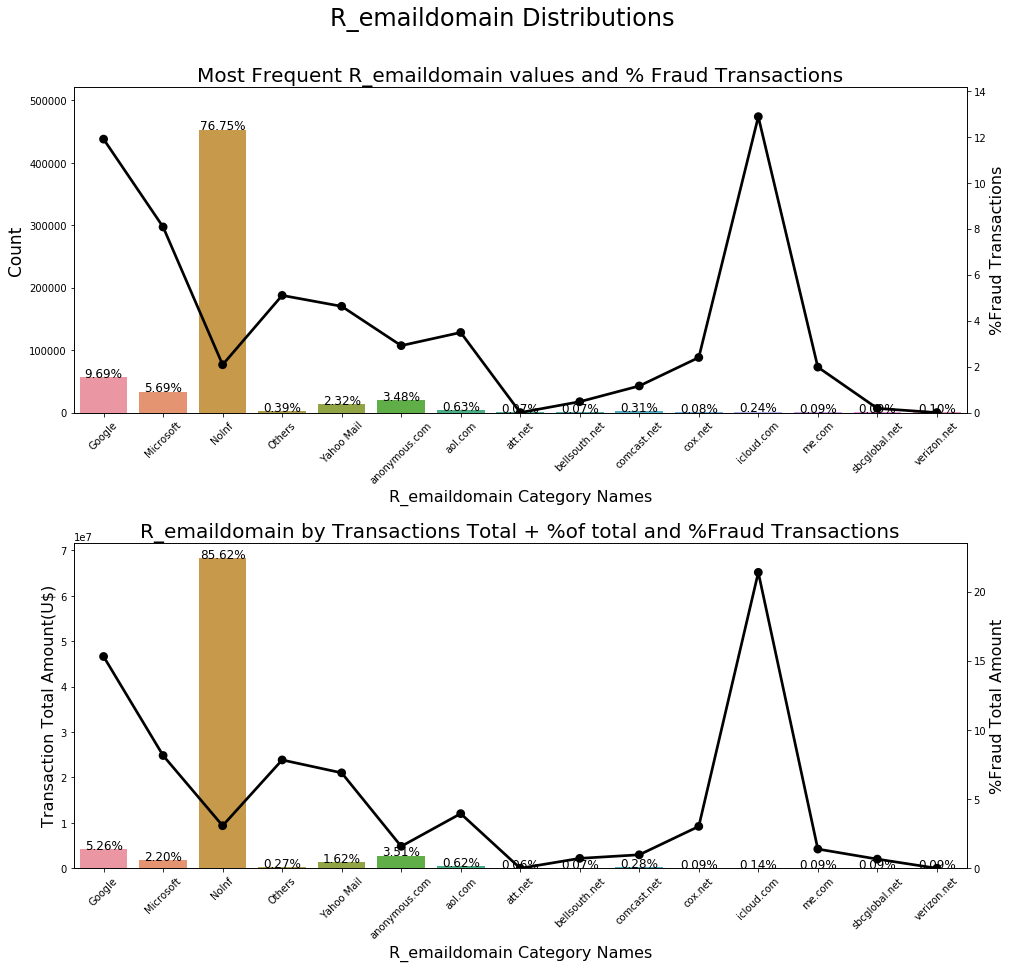

In [35]:
ploting_cnt_amt(df_trans, 'R_emaildomain')

## 1.3. Explore <font color='red'>numerical</font> variables in <font color='red'>transaction table</font>:
### 1.3.1. `'C1'-'C14'` Features

In [36]:
resumetable(df_trans[['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8',
                      'C9', 'C10', 'C11', 'C12', 'C13', 'C14']])

Dataset Shape: (590540, 14)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value
0,C1,float16,0,1495,1.0,1.0,1.0
1,C2,float16,0,1167,1.0,1.0,1.0
2,C3,float16,0,27,0.0,0.0,0.0
3,C4,float16,0,1223,0.0,0.0,0.0
4,C5,float16,0,319,0.0,0.0,0.0
5,C6,float16,0,1291,1.0,1.0,1.0
6,C7,float16,0,1069,0.0,0.0,0.0
7,C8,float16,0,1130,0.0,0.0,0.0
8,C9,float16,0,205,1.0,0.0,1.0
9,C10,float16,0,1122,0.0,0.0,0.0


In [37]:
df_trans[['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8',
                      'C9', 'C10', 'C11', 'C12', 'C13', 'C14']].describe()

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
count,590540.0,590540.0,590540.000000,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0
mean,NaN,NaN,0.005650,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,0.150635,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
min,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,1.0,1.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
50%,1.0,1.0,0.000000,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,1.0
75%,3.0,3.0,0.000000,0.0,1.0,2.0,0.0,0.0,2.0,0.0,2.0,0.0,12.0,2.0
max,4684.0,5692.0,26.000000,2252.0,349.0,2252.0,2256.0,3332.0,210.0,3256.0,3188.0,3188.0,2918.0,1429.0


In [38]:
df_trans.loc[df_trans.C1.isin(df_trans.C1\
                              .value_counts()[df_trans.C1.value_counts() <= 400 ]\
                              .index), 'C1'] = "Others"

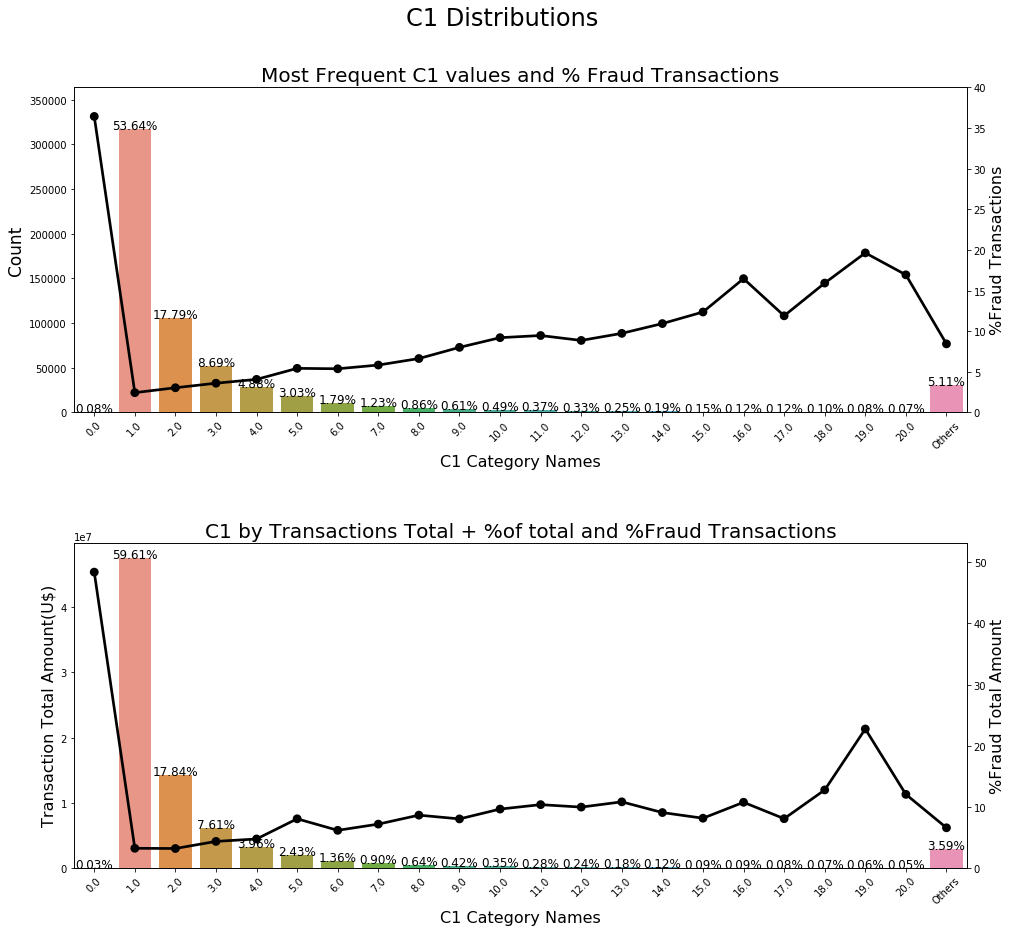

In [39]:
ploting_cnt_amt(df_trans, 'C1')

In [40]:
df_trans.loc[df_trans.C2.isin(df_trans.C2\
                              .value_counts()[df_trans.C2.value_counts() <= 350 ]\
                              .index), 'C2'] = "Others"

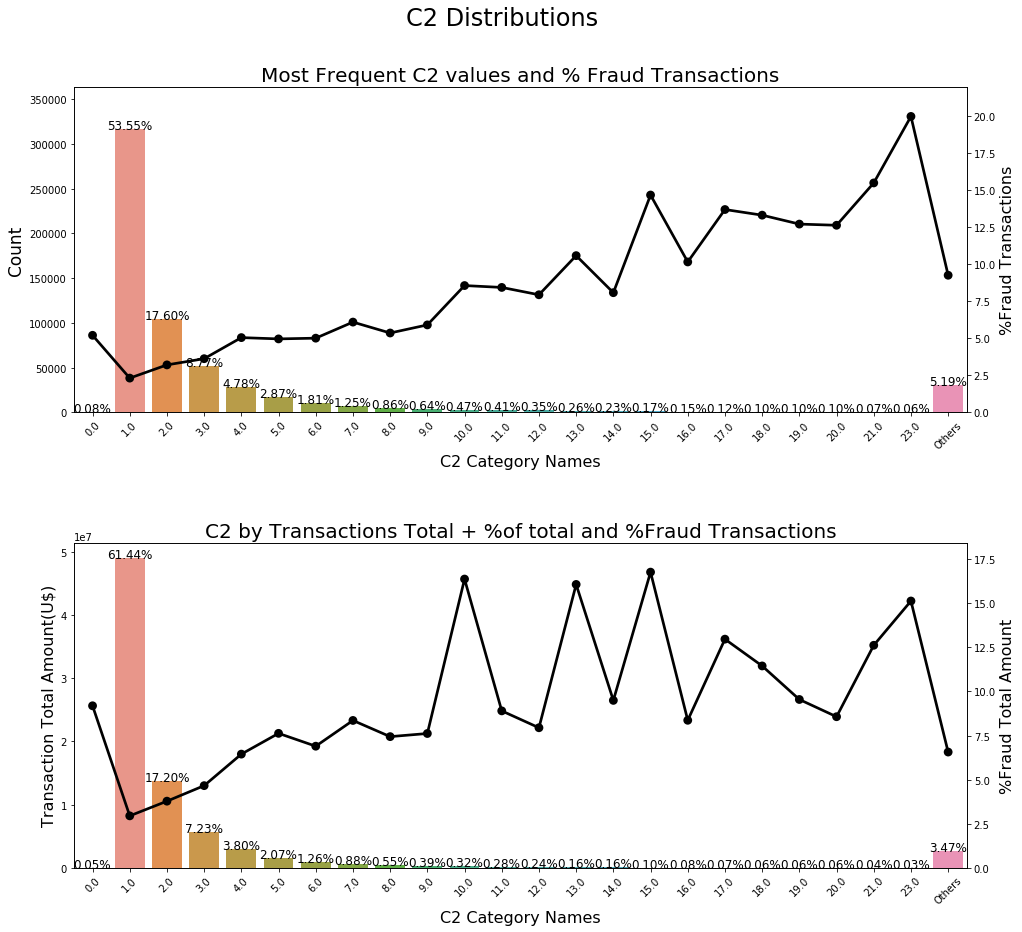

In [41]:
ploting_cnt_amt(df_trans, 'C2')

### 1.3.2. TimeDelta Feature in Transaction table
Let's see if the frauds have some specific hour that has highest % of frauds
#### Converting to Total Days, Weekdays and Hours
We will use the first date as 2017-12-01 and use the delta time to compute datetime features

In [42]:
# https://www.kaggle.com/c/ieee-fraud-detection/discussion/100400#latest-579480
import datetime

START_DATE = '2017-12-01'
startdate = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
df_trans["Date"] = df_trans['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))

df_trans['_Weekdays'] = df_trans['Date'].dt.dayofweek
df_trans['_Hours'] = df_trans['Date'].dt.hour
df_trans['_Days'] = df_trans['Date'].dt.day

### Top Days with highest Total Transaction Amount

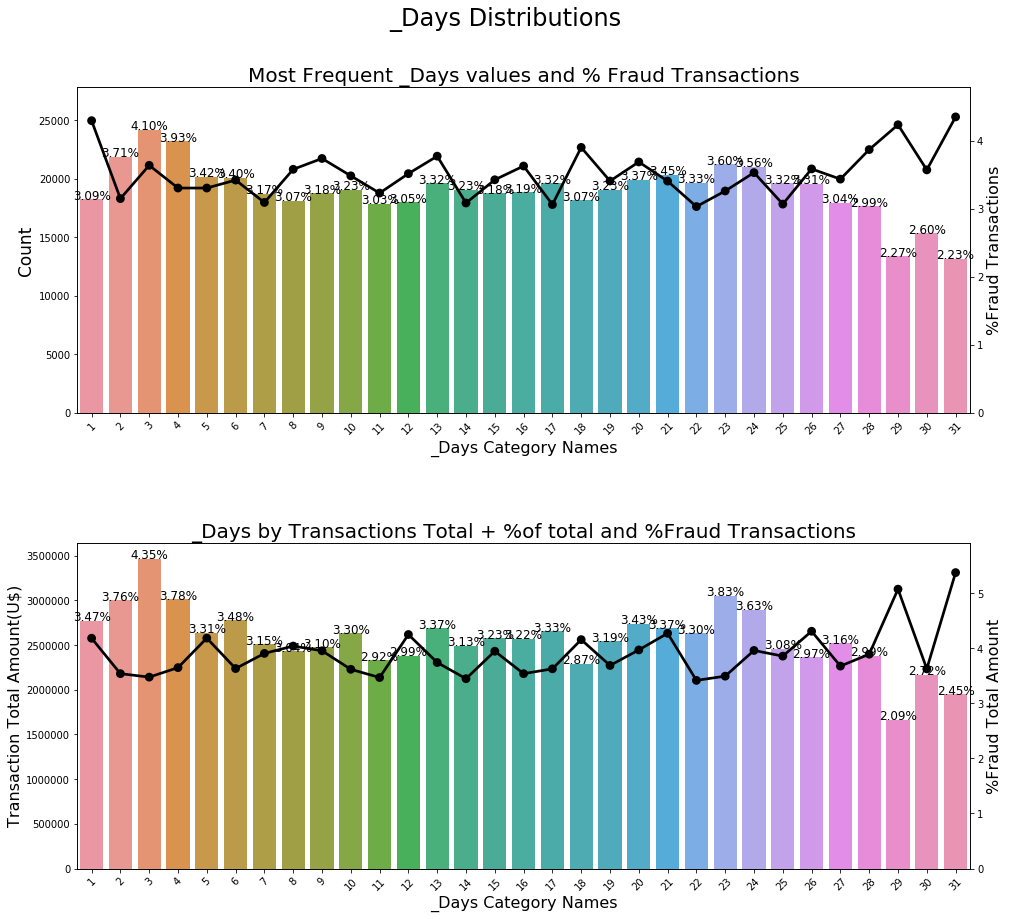

In [43]:
ploting_cnt_amt(df_trans, '_Days')

### Weekday distribution

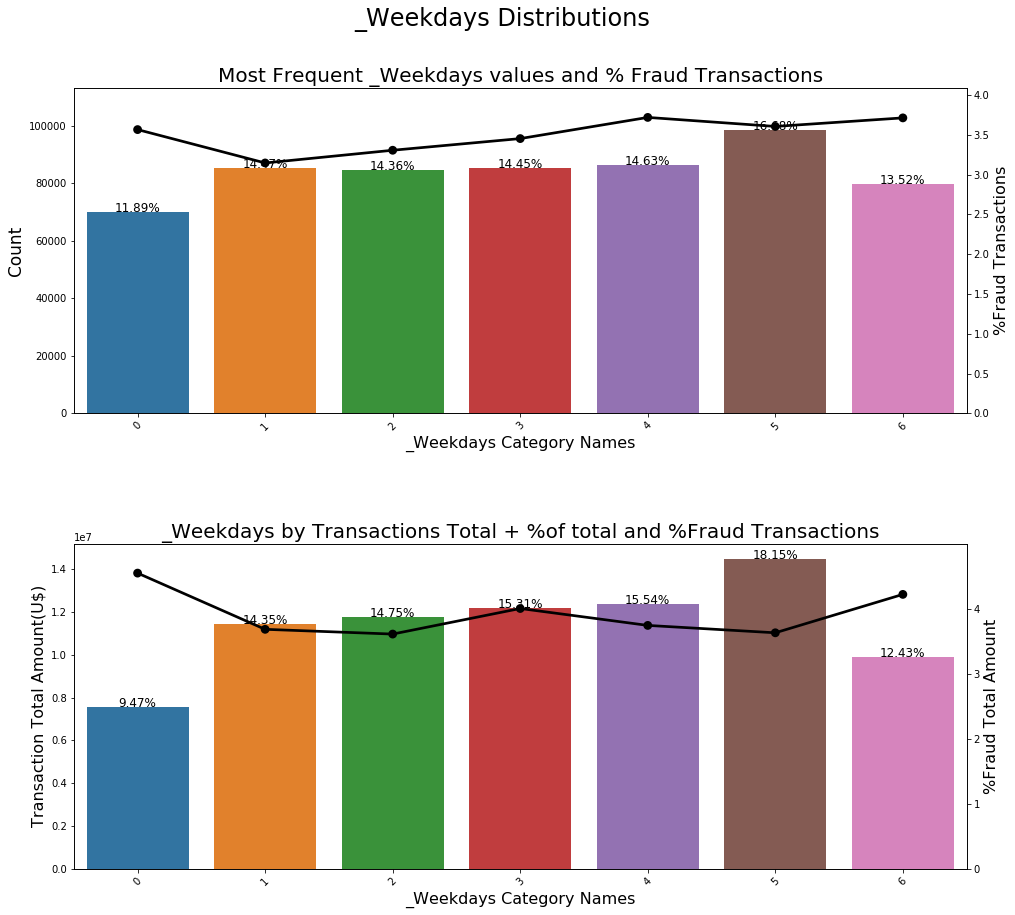

In [44]:
ploting_cnt_amt(df_trans, '_Weekdays')

### Hours distribution

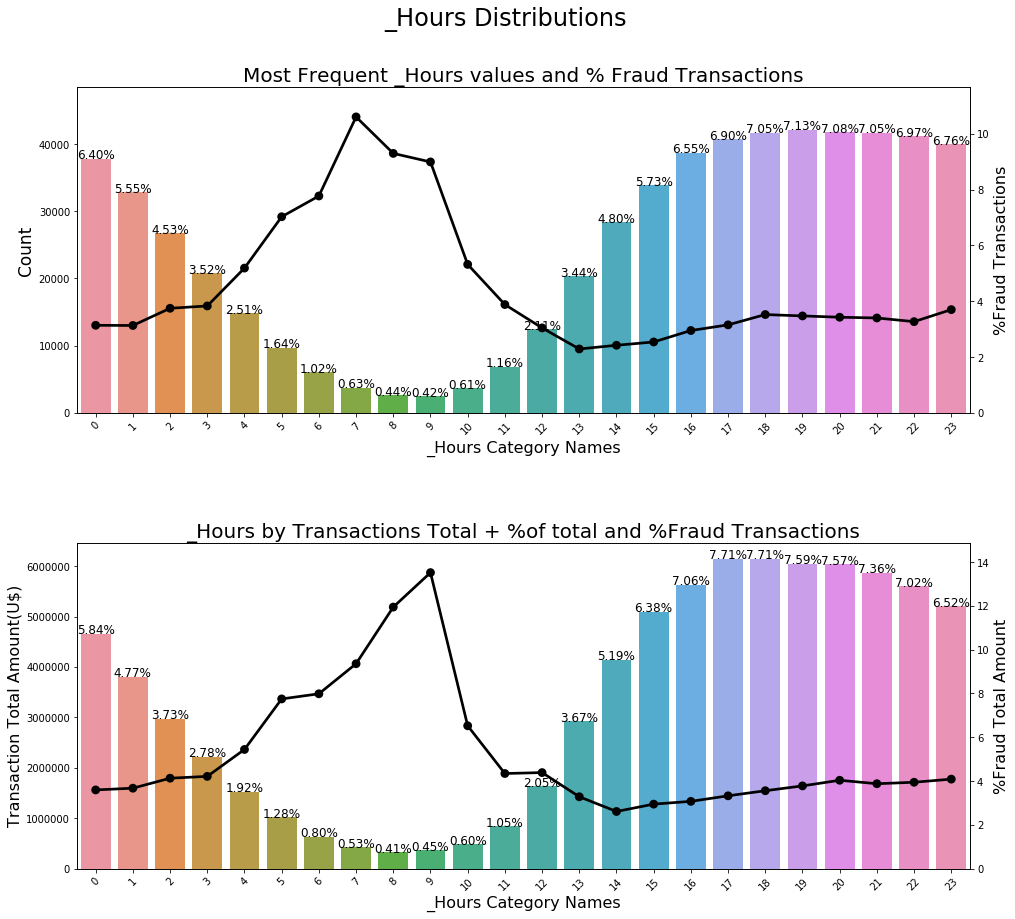

In [45]:
ploting_cnt_amt(df_trans, '_Hours')

### Transactions and Total Amount by each day

In [46]:
# Calling the function to transform the date column in datetime pandas object

#seting some static color options
color_op = ['#5527A0', '#BB93D7', '#834CF7', '#6C941E', '#93EAEA', '#7425FF', '#F2098A', '#7E87AC', 
            '#EBE36F', '#7FD394', '#49C35D', '#3058EE', '#44FDCF', '#A38F85', '#C4CEE0', '#B63A05', 
            '#4856BF', '#F0DB1B', '#9FDBD9', '#B123AC']


dates_temp = df_trans.groupby(df_trans.Date.dt.date)['TransactionAmt'].count().reset_index()
# renaming the columns to apropriate names

# creating the first trace with the necessary parameters
trace = go.Scatter(x=dates_temp['Date'], y=dates_temp.TransactionAmt,
                    opacity = 0.8, line = dict(color = color_op[7]), name= 'Total Transactions')

# Below we will get the total amount sold
dates_temp_sum = df_trans.groupby(df_trans.Date.dt.date)['TransactionAmt'].sum().reset_index()

# using the new dates_temp_sum we will create the second trace
trace1 = go.Scatter(x=dates_temp_sum.Date, line = dict(color = color_op[1]), name="Total Amount",
                        y=dates_temp_sum['TransactionAmt'], opacity = 0.8, yaxis='y2')

#creating the layout the will allow us to give an title and 
# give us some interesting options to handle with the outputs of graphs
layout = dict(
    title= "Total Transactions and Fraud Informations by Date",
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label='1m', step='month', stepmode='backward'),
                dict(count=3, label='3m', step='month', stepmode='backward'),
                dict(count=6, label='6m', step='month', stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(visible = True),
        type='date' ),
    yaxis=dict(title='Total Transactions'),
    yaxis2=dict(overlaying='y',
                anchor='x', side='right',
                zeroline=False, showgrid=False,
                title='Total Transaction Amount')
)

# creating figure with the both traces and layout
fig = dict(data= [trace, trace1,], layout=layout)

#rendering the graphs
iplot(fig) #it's an equivalent to plt.show()

## 1.4. Explore <font color='red'>categorical</font> variables in <font color='red'>Identity table</font>:
### 1.4.1. Feature `'id_12'` - `'id_38'` 

In [47]:
resumetable(df_id[['id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18',
       'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25',
       'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32',
       'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']])

Dataset Shape: (144233, 27)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value
0,id_12,object,0,2,NotFound,NotFound,NotFound
1,id_13,float16,16913,54,NaN,49,52
2,id_14,float16,64189,25,-480,-300,NaN
3,id_15,object,3248,3,New,New,Found
4,id_16,object,14893,2,NotFound,NotFound,Found
5,id_17,float16,4864,104,166,166,121
6,id_18,float16,99120,18,NaN,NaN,NaN
7,id_19,float16,4915,522,542,621,410
8,id_20,float16,4972,394,144,500,142
9,id_21,float16,139074,490,NaN,NaN,NaN


In [48]:
df_id[['id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18',
       'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25',
       'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32',
       'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']].describe(include='all')

,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,...,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38
count,144233,127320.0,80044.0,140985,129340,139369.0,4.511300e+04,139318.0,139261.0,5159.0,...,140978,77565,140282,77586.0,73289,77805,140985,140985,140985,140985
unique,2,NaN,NaN,3,2,NaN,NaN,NaN,NaN,NaN,...,2,75,130,NaN,260,4,2,2,2,2
top,NotFound,NaN,NaN,Found,Found,NaN,NaN,NaN,NaN,NaN,...,Found,Windows 10,chrome 63.0,NaN,1920x1080,match_status:2,T,F,T,F
freq,123025,NaN,NaN,67728,66324,NaN,NaN,NaN,NaN,NaN,...,74926,21155,22000,NaN,16874,60011,77814,134066,110452,73922
mean,NaN,NaN,NaN,NaN,NaN,NaN,inf,NaN,NaN,inf,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,0.0,NaN,NaN,NaN,0.0,1.561523e+00,NaN,NaN,inf,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,10.0,-660.0,NaN,NaN,100.0,1.000000e+01,100.0,100.0,100.0,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,49.0,-360.0,NaN,NaN,166.0,1.300000e+01,266.0,256.0,252.0,...,NaN,NaN,NaN,24.0,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,52.0,-300.0,NaN,NaN,166.0,1.500000e+01,341.0,472.0,252.0,...,NaN,NaN,NaN,24.0,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,52.0,-300.0,NaN,NaN,225.0,1.500000e+01,427.0,533.0,486.5,...,NaN,NaN,NaN,32.0,NaN,NaN,NaN,NaN,NaN,NaN


### Merge `Transanction` and `Identity` tables

In [49]:
df_train = df_trans.merge(df_id, how='left', left_index=True, right_index=True)

In [50]:
def cat_feat_ploting(df, col):
    tmp = pd.crosstab(df[col], df['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

    plt.figure(figsize=(14,10))
    plt.suptitle(f'{col} Distributions', fontsize=22)

    plt.subplot(221)
    g = sns.countplot(x=col, data=df, order=tmp[col].values)
    # plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])

    g.set_title(f"{col} Distribution", fontsize=19)
    g.set_xlabel(f"{col} Name", fontsize=17)
    g.set_ylabel("Count", fontsize=17)
    # g.set_ylim(0,500000)
    for p in g.patches:
        height = p.get_height()
        g.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center", fontsize=14) 

    plt.subplot(222)
    g1 = sns.countplot(x=col, hue='isFraud', data=df, order=tmp[col].values)
    plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
    gt = g1.twinx()
    gt = sns.pointplot(x=col, y='Fraud', data=tmp, color='black', order=tmp[col].values, legend=False)
    gt.set_ylabel("% of Fraud Transactions", fontsize=16)

    g1.set_title(f"{col} by Target(isFraud)", fontsize=19)
    g1.set_xlabel(f"{col} Name", fontsize=17)
    g1.set_ylabel("Count", fontsize=17)

    plt.subplot(212)
    g3 = sns.boxenplot(x=col, y='TransactionAmt', hue='isFraud', 
                       data=df[df['TransactionAmt'] <= 2000], order=tmp[col].values )
    g3.set_title("Transaction Amount Distribuition by ProductCD and Target", fontsize=20)
    g3.set_xlabel("ProductCD Name", fontsize=17)
    g3.set_ylabel("Transaction Values", fontsize=17)

    plt.subplots_adjust(hspace = 0.4, top = 0.85)

    plt.show()

#### Plot columns with few unique values with less missing values (missing <4000):

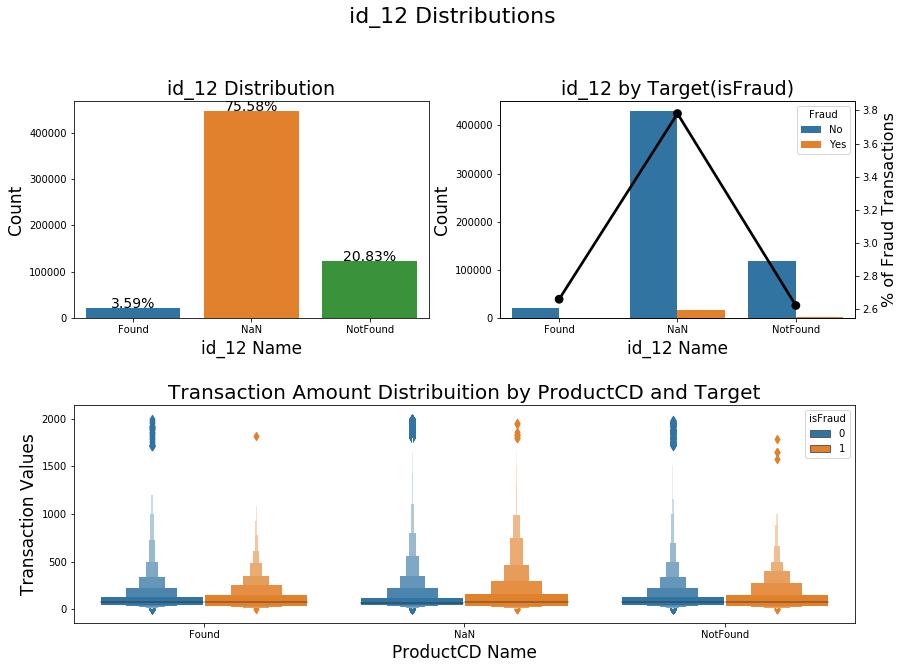

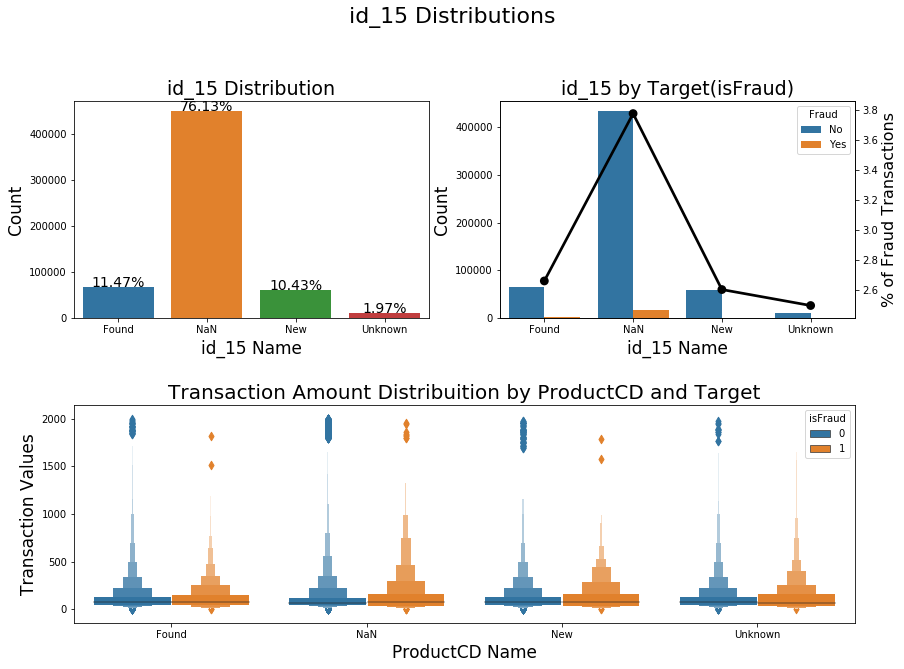

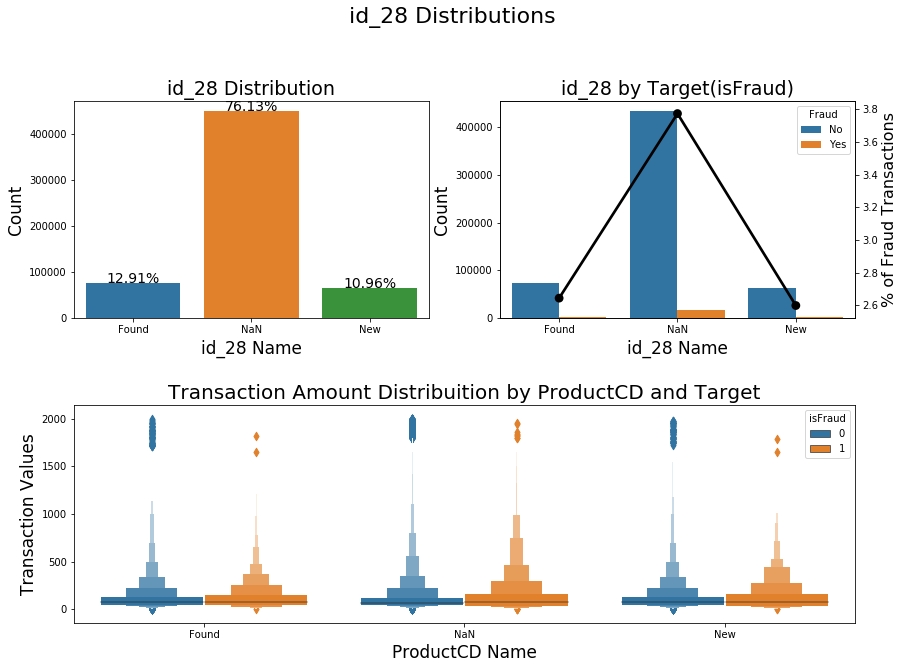

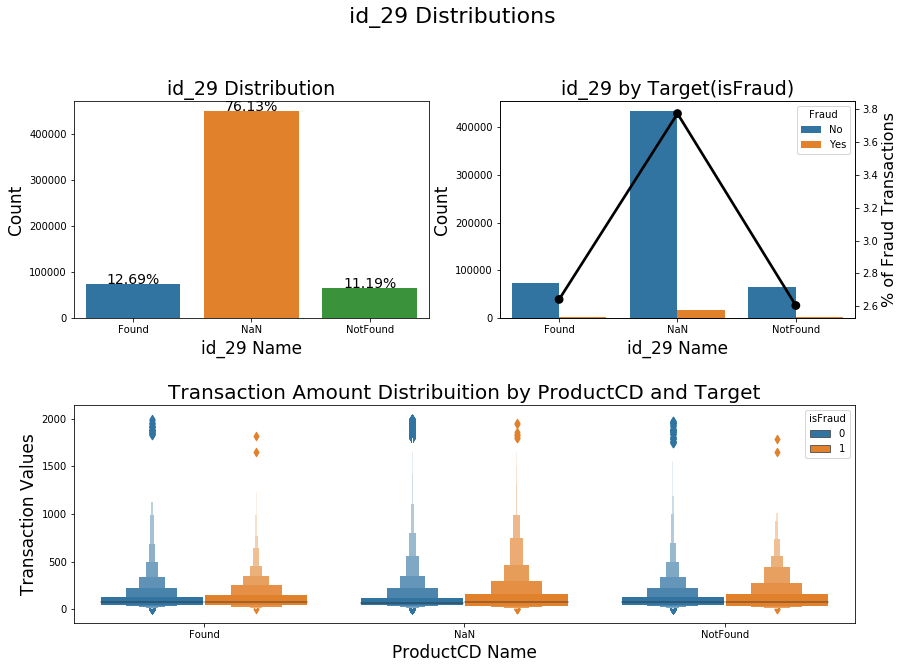

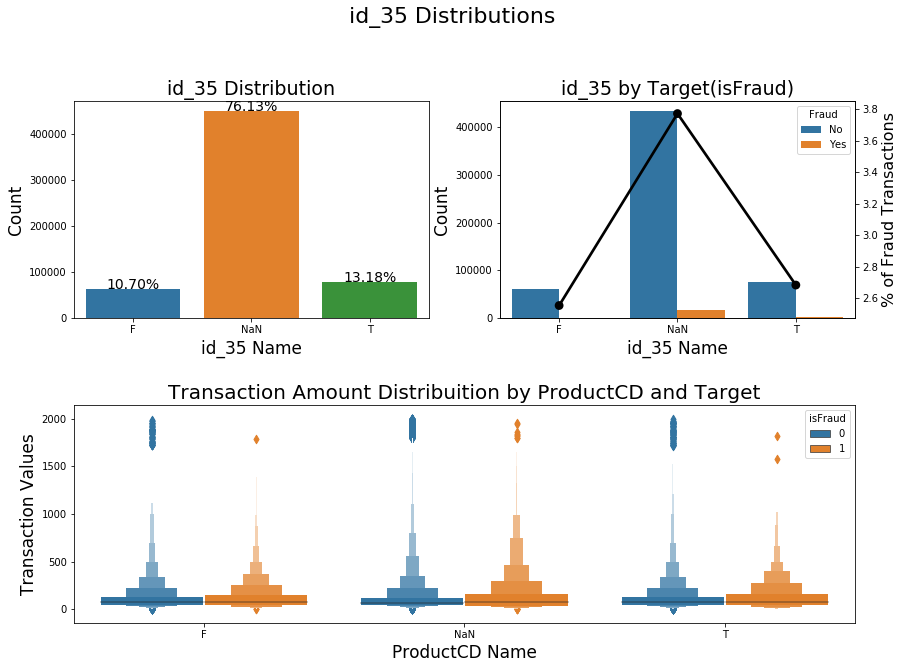

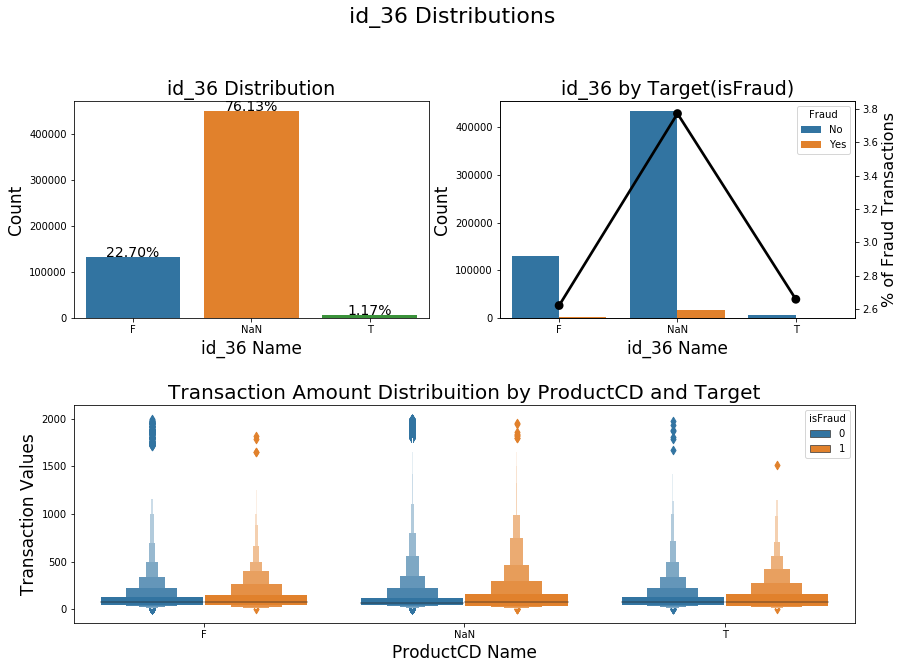

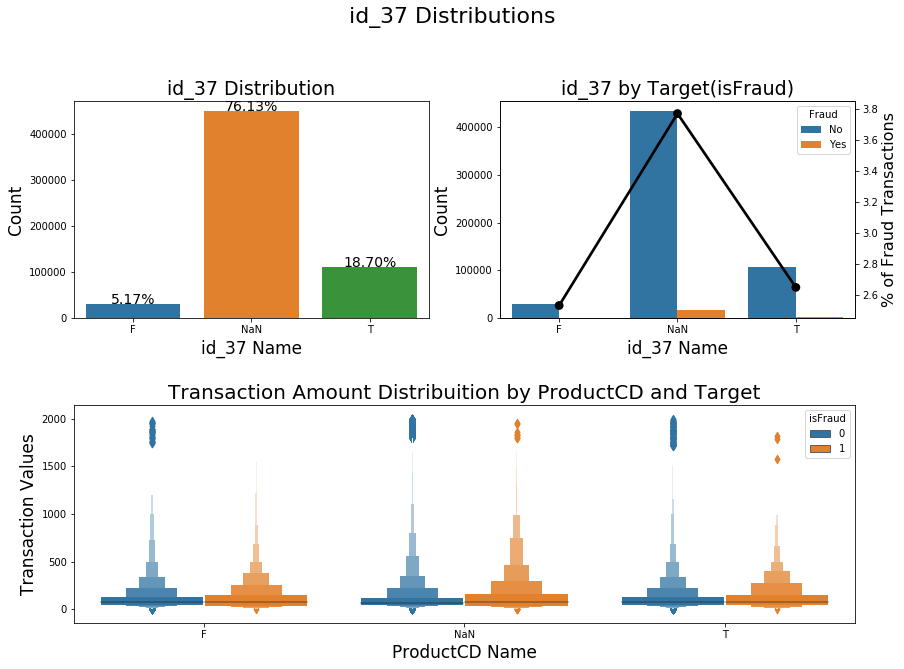

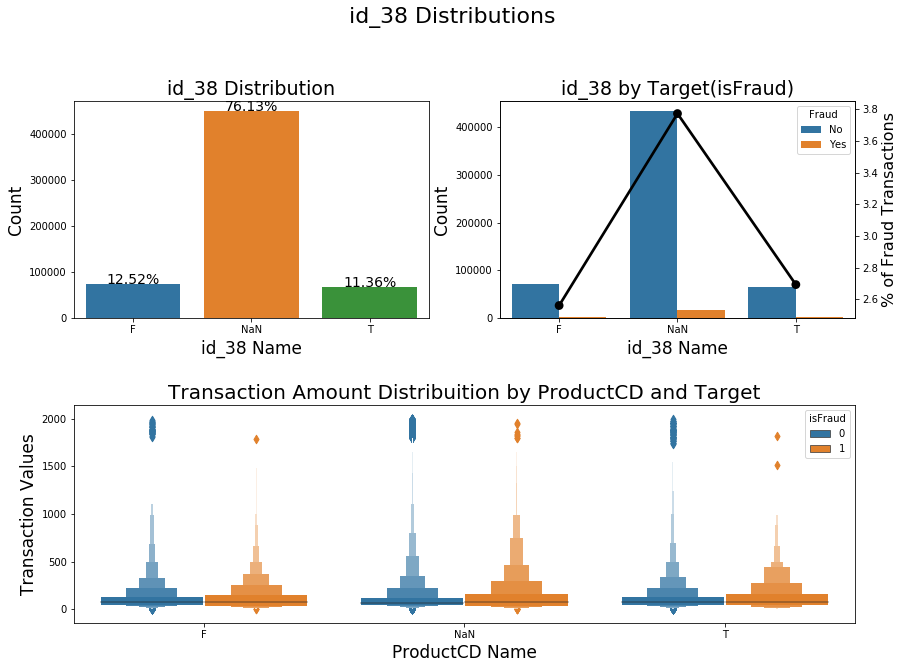

In [51]:
for col in ['id_12', 'id_15', 'id_28', 'id_29', 'id_35', 'id_36', 'id_37', 'id_38']:
    df_train[col] = df_train[col].fillna('NaN')
    cat_feat_ploting(df_train, col)

### `'id31'`, use 8 main types to reduce the dimension:

In [52]:
df_train.loc[df_train['id_31'].str.contains('chrome', na=False), 'id_31'] = 'Chrome'
df_train.loc[df_train['id_31'].str.contains('firefox', na=False), 'id_31'] = 'Firefox'
df_train.loc[df_train['id_31'].str.contains('safari', na=False), 'id_31'] = 'Safari'
df_train.loc[df_train['id_31'].str.contains('edge', na=False), 'id_31'] = 'Edge'
df_train.loc[df_train['id_31'].str.contains('ie', na=False), 'id_31'] = 'IE'
df_train.loc[df_train['id_31'].str.contains('samsung', na=False), 'id_31'] = 'Samsung'
df_train.loc[df_train['id_31'].str.contains('opera', na=False), 'id_31'] = 'Opera'
df_train['id_31'].fillna("NAN", inplace=True)
df_train.loc[df_train.id_31.isin(df_train.id_31.value_counts()[df_train.id_31.value_counts() < 200].index), 'id_31'] = "Others"

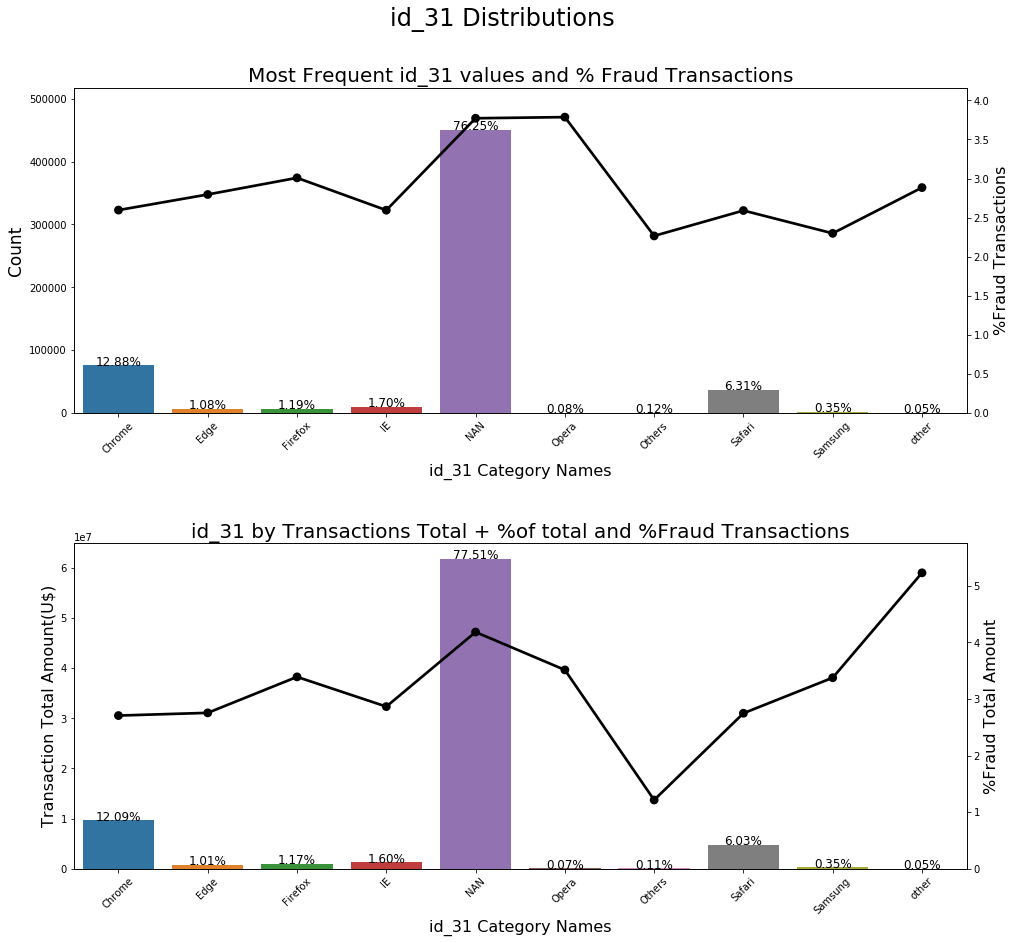

In [53]:
ploting_cnt_amt(df_train, 'id_31')

### 1.4.2. `'DeviceType'`

In [54]:
df_train['DeviceType'] = df_train['DeviceType'].fillna('NaN')

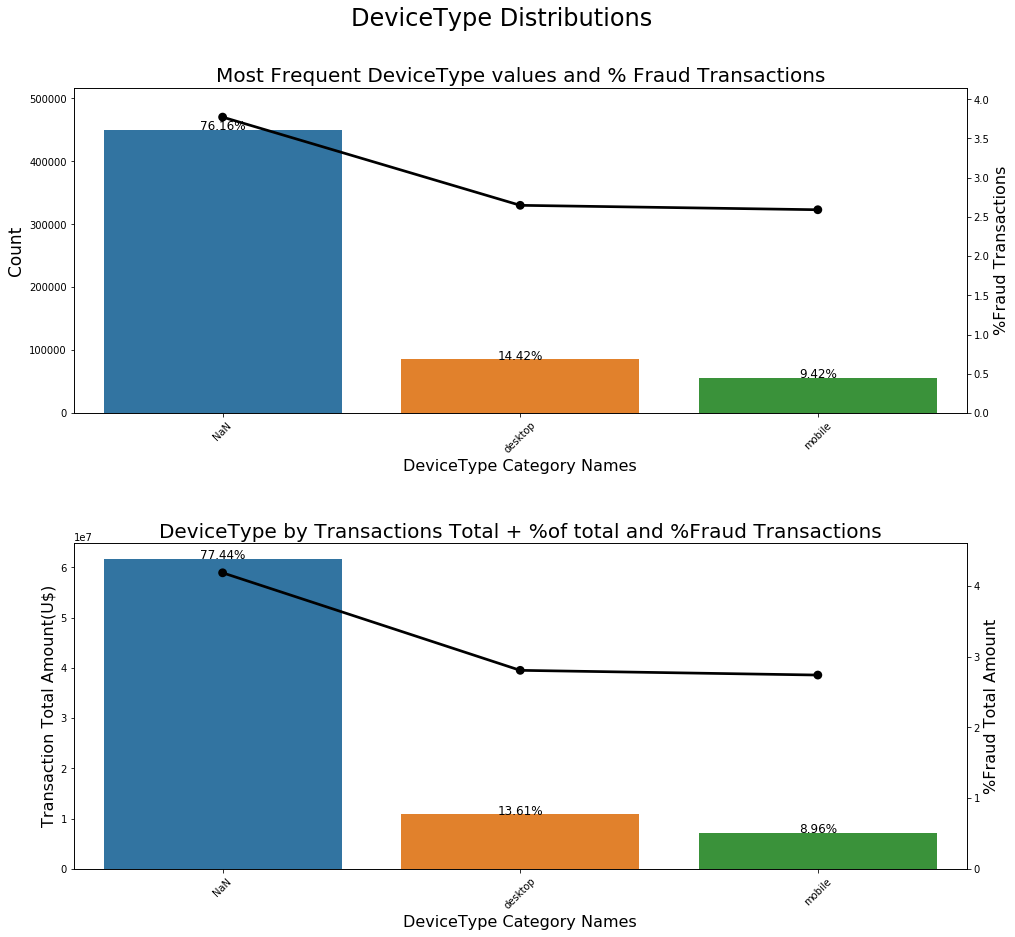

In [55]:
ploting_cnt_amt(df_train, 'DeviceType')

# 2. Feature Engineering and Feature Selection
## 2.1. asanction table left join Identity table on `TrasanctionID`.

In [3]:
#df_trans = pd.read_csv('/Users/mingkuanwu/Desktop/Kaggle_Competetions/Fraud_Detection/input/train_transaction.csv')#, index_col='TransactionID')
#df_test_trans = pd.read_csv('/Users/mingkuanwu/Desktop/Kaggle_Competetions/Fraud_Detection/input/test_transaction.csv')#, index_col='TransactionID')

#df_id = pd.read_csv('/Users/mingkuanwu/Desktop/Kaggle_Competetions/Fraud_Detection/input/train_identity.csv')#, index_col='TransactionID')
#df_test_id = pd.read_csv('/Users/mingkuanwu/Desktop/Kaggle_Competetions/Fraud_Detection/input/test_identity.csv')#, index_col='TransactionID')

#sample_submission = pd.read_csv('/Users/mingkuanwu/Desktop/Kaggle_Competetions/Fraud_Detection/input/sample_submission.csv', index_col='TransactionID')

df_trans = pd.read_csv('/home/mingkuan/Desktop/Fraud_Detection/input/train_transaction.csv')
df_test_trans = pd.read_csv('/home/mingkuan/Desktop/Fraud_Detection/input/test_transaction.csv')

df_id = pd.read_csv('/home/mingkuan/Desktop/Fraud_Detection/input/train_identity.csv')
df_test_id = pd.read_csv('/home/mingkuan/Desktop/Fraud_Detection/input/test_identity.csv')

sample_submission = pd.read_csv('/home/mingkuan/Desktop/Fraud_Detection/input/sample_submission.csv', index_col='TransactionID')

df_train = df_trans.merge(df_id, how='left', left_index=True, right_index=True, on='TransactionID')
df_test = df_test_trans.merge(df_test_id, how='left', left_index=True, right_index=True, on='TransactionID')

print(df_train.shape)
print(df_test.shape)

# y_train = df_train['isFraud'].copy()
del df_trans, df_id, df_test_trans, df_test_id

(590540, 434)
(506691, 433)


In [4]:
df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)

Mem. usage decreased to 645.97 Mb (67.0% reduction)
Mem. usage decreased to 561.50 Mb (66.5% reduction)


## 2.2. Feature Engineering on `'TransactionAmt'`

In [ ]:
df_train['Trans_min_mean'] = df_train['TransactionAmt'] - df_train['TransactionAmt'].mean()
df_train['Trans_min_std'] = df_train['Trans_min_mean'] / df_train['TransactionAmt'].std()
df_test['Trans_min_mean'] = df_test['TransactionAmt'] - df_test['TransactionAmt'].mean()
df_test['Trans_min_std'] = df_test['Trans_min_mean'] / df_test['TransactionAmt'].std()

In [ ]:
df_train['TransactionAmt_to_mean_card1'] = df_train['TransactionAmt'] / df_train.groupby(['card1'])['TransactionAmt'].transform('mean')
df_train['TransactionAmt_to_mean_card4'] = df_train['TransactionAmt'] / df_train.groupby(['card4'])['TransactionAmt'].transform('mean')
df_train['TransactionAmt_to_std_card1'] = df_train['TransactionAmt'] / df_train.groupby(['card1'])['TransactionAmt'].transform('std')
df_train['TransactionAmt_to_std_card4'] = df_train['TransactionAmt'] / df_train.groupby(['card4'])['TransactionAmt'].transform('std')

df_test['TransactionAmt_to_mean_card1'] = df_test['TransactionAmt'] / df_test.groupby(['card1'])['TransactionAmt'].transform('mean')
df_test['TransactionAmt_to_mean_card4'] = df_test['TransactionAmt'] / df_test.groupby(['card4'])['TransactionAmt'].transform('mean')
df_test['TransactionAmt_to_std_card1'] = df_test['TransactionAmt'] / df_test.groupby(['card1'])['TransactionAmt'].transform('std')
df_test['TransactionAmt_to_std_card4'] = df_test['TransactionAmt'] / df_test.groupby(['card4'])['TransactionAmt'].transform('std')

In [6]:
df_train['TransactionAmt'] = np.log(df_train['TransactionAmt'])
df_test['TransactionAmt'] = np.log(df_test['TransactionAmt'])

In [7]:
df_train.shape

(590540, 438)

## 2.3. Use PCA to do feature selection on numerical variables `'Vxxx'` 

In [11]:
df_test['isFraud'] = 'test'
df = pd.concat([df_train, df_test], axis=0, sort=False )
df = df.reset_index()
df = df.drop('index', axis=1)
df.shape

(1097231, 476)

In [12]:
def PCA_change(df, cols, n_components, prefix='PCA_', rand_seed=4):
    pca = PCA(n_components=n_components, random_state=rand_seed)

    principalComponents = pca.fit_transform(df[cols])

    principalDf = pd.DataFrame(principalComponents)

    df.drop(cols, axis=1, inplace=True)

    principalDf.rename(columns=lambda x: str(prefix)+str(x), inplace=True)

    df = pd.concat([df, principalDf], axis=1)
    
    return df

In [13]:
mas_v = df_train.columns[55:394]

In [14]:
from sklearn.preprocessing import minmax_scale
from sklearn.decomposition import PCA
# from sklearn.cluster import KMeans

In [15]:
for col in mas_v:
    df[col] = df[col].fillna((df[col].min() - 2))
    df[col] = (minmax_scale(df[col], feature_range=(0,1)))
    
df = PCA_change(df, mas_v, prefix='PCA_V_', n_components=30)
df.shape

(1097231, 167)

In [16]:
df = reduce_mem_usage(df)

Mem. usage decreased to 678.07 Mb (8.5% reduction)


## 2.4.  Preprocessing and One-hot encoding categorical data

### 2.4.1. Mapping emails

In [5]:
emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 
          'scranton.edu': 'other', 'optonline.net': 'other', 'hotmail.co.uk': 'microsoft',
          'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo',
          'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft', 
          'aim.com': 'aol', 'hotmail.de': 'microsoft', 'centurylink.net': 'centurylink',
          'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 'gmx.de': 'other',
          'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 
          'protonmail.com': 'other', 'hotmail.fr': 'microsoft', 'windstream.net': 'other', 
          'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo', 'yahoo.de': 'yahoo',
          'servicios-ta.com': 'other', 'netzero.net': 'other', 'suddenlink.net': 'other',
          'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft',
          'verizon.net': 'yahoo', 'msn.com': 'microsoft', 'q.com': 'centurylink', 
          'prodigy.net.mx': 'att', 'frontier.com': 'yahoo', 'anonymous.com': 'other', 
          'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo', 
          'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 'mail.com': 'other', 
          'bellsouth.net': 'other', 'embarqmail.com': 'centurylink', 'cableone.net': 'other', 
          'hotmail.es': 'microsoft', 'mac.com': 'apple', 'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 
          'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other', 'cox.net': 'other',
          'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}

us_emails = ['gmail', 'net', 'edu']

# https://www.kaggle.com/c/ieee-fraud-detection/discussion/100499#latest-579654
for c in ['P_emaildomain', 'R_emaildomain']:
    df_train[c + '_bin'] = df_train[c].map(emails)
    df_test[c + '_bin'] = df_test[c].map(emails)
    # [nan, 'google', 'microsoft', 'yahoo', 'other', 'aol', 'apple', 'spectrum', 'att', 'centurylink']
    
    df_train[c + '_suffix'] = df_train[c].map(lambda x: str(x).split('.')[-1])
    df_test[c + '_suffix'] = df_test[c].map(lambda x: str(x).split('.')[-1])
    # ['nan', 'com', 'net', 'mx', 'gmail', 'es', 'de', 'fr', 'uk', 'jp']
    
    df_train[c + '_suffix'] = df_train[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')
    df_test[c + '_suffix'] = df_test[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')
    # ['nan', 'com', 'us', 'mx', 'es', 'de', 'fr', 'uk', 'jp']

### 2.4.2. `'card'` dimension reduction:

In [20]:
df.loc[df.card3.isin(df.card3.value_counts()[df.card3.value_counts() < 200].index), 'card3'] = "Others"
df.loc[df.card5.isin(df.card5.value_counts()[df.card5.value_counts() < 300].index), 'card5'] = "Others"

df.loc[df.card1.isin(df.card1.value_counts()[df.card1.value_counts() < 1000].index), 'card1'] = "Others"
df.loc[df.card2.isin(df.card2.value_counts()[df.card2.value_counts() < 1000].index), 'card2'] = "Others"

### 2.4.3. `'addr1'` and `'addr2'` dimension reduction:

In [18]:
df.loc[df.addr1.isin(df.addr1.value_counts()[df.addr1.value_counts() <= 5000 ].index), 'addr1'] = "Others"
df.loc[df.addr2.isin(df.addr2.value_counts()[df.addr2.value_counts() <= 50 ].index), 'addr2'] = "Others"

### 2.4.4. `'DeviceInfo'` dimension reduction:

In [ ]:
df.loc[df.DeviceInfo.isin(df.DeviceInfo.value_counts()[df.DeviceInfo.value_counts() <= 1000 ].index), 'DeviceInfo'] = "Others"

### 2.4.5. One-hot encoding on all categorical varaibles

In [ ]:
to_dummy = ['ProductCD', 'Card1', 'Card2','Card3','Card4','Card5','Card6', 'addr1', 'addr2', 
           'P_emaildomain_bin', 'P_emaildomain_suffix', 'R_emaildomain_bin', 'R_emaildomain_suffix', 
           'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 
           'DeviceType', 'DeviceInfo'
           #,'id_12',..., 'id_38' 
           ]
for i in to_dummy:
    dummy = pd.get_dummies(df[i],prefix=i)
    df = pd.concat([df,dummy],axis=1)
    df = df.drop(i,axis=1)

### 2.4.6. (Use Random Forest to select categorical features after one-encoding) 

## 2.5. Train test split back

In [ ]:
df_train, df_test = df[df['isFraud'] != 'test'], df[df['isFraud'] == 'test'].drop('isFraud', axis=1)

## 2.6. Define X and Y

In [ ]:
X_train = df_train.sort_values('TransactionDT').drop(['isFraud', 
                                                      'TransactionDT', 
                                                      #'Card_ID'
                                                     ],
                                                     axis=1)
y_train = df_train.sort_values('TransactionDT')['isFraud'].astype(bool)

X_test = df_test.sort_values('TransactionDT').drop(['TransactionDT',
                                                    #'Card_ID'
                                                   ], 
                                                   axis=1)
del df_train

# 3. Model training (to be continued...)